In [1]:
import sys
import numpy as np
import time
#!python -m pip install ujson
import ujson as json

#!python -m pip install matplotlib
%matplotlib inline
from matplotlib import pyplot as plt 
import random

#!conda install pandas=1.0.5 --yes
 
import pandas as pd 
from pandas.core.common import flatten
import itertools
import re
from simple_colors import *
import networkx as nx
from networkx.readwrite import json_graph

In [2]:
print(sys.executable)
#import importlib.util 
#print(sys.modules)
#import pandas as pd
pd.__version__ 
pd.set_option("display.max_columns", None)

/xdisk/msurdeanu/fanluo/miniconda3/envs/spacy/bin/python


In [3]:
import sys
sys.path.insert(0, '/xdisk/msurdeanu/fanluo/miniconda3/envs/hotpotqa/lib/python3.8/site-packages') 

import os
os.chdir('/xdisk/msurdeanu/fanluo/hotpotQA/') 
from util import get_buckets

In [4]:
import string 
def _normalize_text(s):
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

In [5]:
import re
import string
# def findWholeWord(w):
#     return re.compile(r'\b({0})\b'.format(re.escape(w.strip(string.punctuation))), flags=re.IGNORECASE).search
#     # strip(string.punctuation) to remove heading and ending punctuations in the answer, otherwise can not found correctly if heading or ending punctuations appears
    
def findWord(w, context):
    if(w == ''):
        return False
    if(len(list(re.finditer(str(w), str(context), re.IGNORECASE))) > 0):
        return True
    else:
        return False

In [6]:
def vis_graph(H, nodes, color_nodes):
    
    G = H.subgraph(nodes)  # Returns a subgraph containing nodes in nbunch
    print(black("nodes to draw", ['bold']), G.nodes())
    
    plt.figure(figsize=(20,10))
    color_map = dict.fromkeys(color_nodes, 1)   
    values = [color_map.get(node, 0.6) for node in G.nodes()]  # beside color_nodes, other nodes are 0.6 
    pos = nx.random_layout(G)
    edge_labels = nx.get_edge_attributes(G, 'src')
    nx.draw(G, pos, node_color=values, with_labels=True, node_size=800, font_size=20, font_color='blue')
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15) 
    plt.show() 
     
    for n, nbrs in G.adj.items():  # each node and its neighbors   
        for nbr, eattr in nbrs.items(): # each neighbor and edge attr
            print(f"({n}, {nbr}, {eattr})")
            
    return

## HopotQA dataset

### Train Statistics

In [7]:
with open('/xdisk/msurdeanu/fanluo/hotpotQA/Data/hotpot_train_v1.1.json') as json_file:      
    data = json_file.readlines()
    data = list(map(json.loads, data)) 
train_question_df = pd.DataFrame(data[0])
del data
import gc
gc.collect()

0

In [8]:
pd.set_option('display.max_columns', None)   # show all columns
train_question_df.head(3)

,supporting_facts,level,question,context,answer,_id,type
0,"[[Arthur's Magazine, 0], [First for Women, 0]]",medium,Which magazine was started first Arthur's Maga...,"[[Radio City (Indian radio station), [Radio Ci...",Arthur's Magazine,5a7a06935542990198eaf050,comparison
1,"[[Oberoi family, 0], [The Oberoi Group, 0]]",medium,The Oberoi family is part of a hotel company t...,"[[Ritz-Carlton Jakarta, [The Ritz-Carlton Jaka...",Delhi,5a879ab05542996e4f30887e,bridge
2,"[[Allie Goertz, 0], [Allie Goertz, 1], [Allie ...",hard,Musician and satirist Allie Goertz wrote a son...,"[[Lisa Simpson, [Lisa Marie Simpson is a ficti...",President Richard Nixon,5a8d7341554299441c6b9fe5,bridge


In [9]:
train_question_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90447 entries, 0 to 90446
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   supporting_facts  90447 non-null  object
 1   level             90447 non-null  object
 2   question          90447 non-null  object
 3   context           90447 non-null  object
 4   answer            90447 non-null  object
 5   _id               90447 non-null  object
 6   type              90447 non-null  object
dtypes: object(7)
memory usage: 4.8+ MB


#### level

In [10]:
# Distribution of difficulty levels
grouped = train_question_df.groupby(['level'])
level_counts = grouped.size()  # count of each 
level_counts

level
easy      17972
hard      15661
medium    56814
dtype: int64

#### type

In [11]:
train_question_df.type.describe()

count      90447
unique         2
top       bridge
freq       72991
Name: type, dtype: object

In [12]:
# Distribution of type
grouped = train_question_df.groupby(['type'])
type_counts = grouped.size()  # count of each 
type_counts

type
bridge        72991
comparison    17456
dtype: int64

#### context 

In [13]:
train_question_df['context_flattened'] = train_question_df['context'].map(lambda x: list(flatten(x)))

In [14]:
train_question_df['context_joint'] = train_question_df['context_flattened'].map(lambda x: " ".join(x) )

In [15]:
train_question_df.context_joint  = train_question_df.context_joint.map(_normalize_text)  
# train_question_df.context_joint  = train_question_df.context_joint.str.lower().map(lambda x:  " ".join(re.sub(r'"', r'', x).split()) ) 

In [16]:
train_question_df.head(1)

,supporting_facts,level,question,context,answer,_id,type,context_flattened,context_joint
0,"[[Arthur's Magazine, 0], [First for Women, 0]]",medium,Which magazine was started first Arthur's Maga...,"[[Radio City (Indian radio station), [Radio Ci...",Arthur's Magazine,5a7a06935542990198eaf050,comparison,"[Radio City (Indian radio station), Radio City...",radio city indian radio station radio city is ...


In [17]:
train_question_df.context_flattened.str.len().describe()  # statistic of number of context sentences, including title

count    90447.000000
mean        50.891804
std         11.363687
min          4.000000
25%         44.000000
50%         50.000000
75%         57.000000
max        154.000000
Name: context_flattened, dtype: float64

In [18]:
grouped = train_question_df.groupby(train_question_df.context_flattened.str.len())
num_of_context_sentences = grouped.size()  # count of each 
num_of_context_sentences

context_flattened
4       8
5      35
6      49
7      44
8      49
       ..
143     2
144     1
146     4
152     1
154     2
Length: 142, dtype: int64

In [19]:
num_of_context_sentences.max()

3788

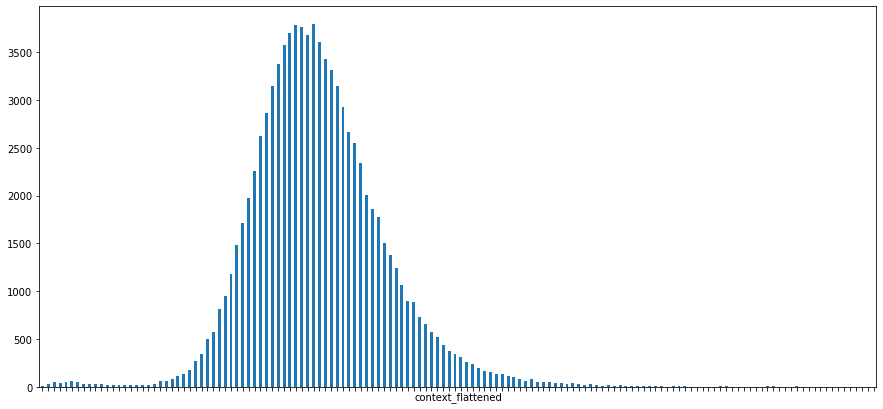

In [20]:
# distribution of number of context sentences
plot = num_of_context_sentences.plot(kind = 'bar', figsize=(15, 7))
plt.xticks(rotation=0)                                    # show label text horizontally
plt.setp(plot.axes.get_xticklabels(), visible=False)      # hide all labels
plt.setp(plot.axes.get_xticklabels()[::5], visible=True)  # set every 5 labels visible
plt.show() 

#### answer

In [21]:
train_question_df.answer = train_question_df.answer.map(_normalize_text)  # apply _normalize_text(answer)  

In [22]:
train_question_df.answer.str.split(' ').str.len().describe()  # statistic of number of words in the answer

count    90447.000000
mean         2.144328
std          1.641551
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         76.000000
Name: answer, dtype: float64

In [23]:
grouped = train_question_df.groupby(train_question_df.answer.str.split(' ').str.len())
num_of_answer_words = grouped.size()  
num_of_answer_words

answer
1     32984
2     32024
3     16665
4      4980
5      2003
6       663
7       328
8       159
9       112
10       85
11       70
12       42
13       45
14       42
15       30
16       34
17       23
18       27
19       18
20       17
21       11
22       14
23       12
24       11
25       12
26        5
27        4
28        3
29        3
30        5
31        2
32        3
33        3
34        1
35        2
38        1
40        1
57        1
72        1
76        1
dtype: int64

In [24]:
# number of questions with answer 'yes'
train_question_df.loc[train_question_df['answer'] == 'yes'].shape[0]

2748

In [25]:
# number of comparison questions with answer 'yes'
train_question_df.loc[(train_question_df['answer'] == 'yes') & (train_question_df['type'] == 'comparison')].shape[0]

2748

In [26]:
# number of questions with answer 'no'
train_question_df.loc[train_question_df['answer'] == 'no'].shape[0]

2735

In [27]:
# number of comparison questions with answer 'no'
train_question_df.loc[(train_question_df['answer'] == 'no') & (train_question_df['type'] == 'comparison')].shape[0]

2735

questions with answer yes/no are all comparison questions, and (17456-2735-2748) = 68.6% comparison questions have span answers 

In [28]:
# train_question_df["normalized_answer_in_context"] = train_question_df.apply(lambda row: row['answer'] in row['context_joint'], axis=1)

In [29]:
train_question_df['normalized_answer_in_context'] = train_question_df.apply(lambda row:  findWord(row['answer'], row['context_joint']) == True , axis = 1)

In [30]:
train_question_df.normalized_answer_in_context.describe()

count     90447
unique        2
top        True
freq      87837
Name: normalized_answer_in_context, dtype: object

87837 questions' answer in the context, 90447-87837 = 2610 questions' answer are not in the context

In [31]:
train_question_df.loc[(train_question_df['normalized_answer_in_context'] == False) & (train_question_df['answer'] != 'yes') & (train_question_df['answer'] != 'no')  & (train_question_df['answer'] != '')]

,supporting_facts,level,question,context,answer,_id,type,context_flattened,context_joint,normalized_answer_in_context


In [32]:
train_question_df.loc[(train_question_df['normalized_answer_in_context'] == False)].answer.describe()

count     2610
unique       3
top        yes
freq      2586
Name: answer, dtype: object

For those answers are not in the context, most normalized_answer are 'yes', some are 'no' and '', only one exception is train_question_df.iloc[38543]   

In [33]:
train_question_df.iloc[38543].answer

'3oh3'

In [34]:
train_question_df.iloc[38543].context_joint

'regina spektor regina ilyinichna spektor russian реги́нa ильи́нична спе́ктор born february 18 1980 is russianborn american singersongwriter and pianist she was born in moscow former soviet union now russia and began classical training on piano at age of six when she was nine years old her family emigrated from soviet union to united states where she continued her classical training into her teenage years she began to write original songs shortly thereafter 3oh3 3oh 3 pronounced three oh three is american electronic music duo from boulder colorado made up of sean foreman and nathaniel motte they are best known for their single dont trust me from their album want which reached number seven on billboard hot 100 their second single remix of starstrukk featuring katy perry from want was top ten hit in united kingdom ireland finland poland and australia they gained further recognition by featuring kesha on song my first kiss which was made lead single from their album streets of gold album 

#### supporting facts

In [35]:
train_question_df['invalid_supporting_facts_ids'] = train_question_df.apply(lambda row: True in [sp_idx >= len(dict(row['context'])[sp_t]) for (sp_t, sp_idx) in row['supporting_facts']], axis = 1)

In [36]:
train_question_df['invalid_supporting_facts_ids'].describe()

count     90447
unique        2
top       False
freq      90425
Name: invalid_supporting_facts_ids, dtype: object

22 questions have at least a supporting fact id out of range. That is, supporting fact id >= total num of sentence in the paragraph

In [37]:
train_question_df.loc[train_question_df['invalid_supporting_facts_ids']==True]

,supporting_facts,level,question,context,answer,_id,type,context_flattened,context_joint,normalized_answer_in_context,invalid_supporting_facts_ids
514,"[[Pro Wrestling Fujiwara Gumi, 0], [Pro Wrestl...",medium,What wrestling promotion was formed by the cur...,"[[NEVER Openweight Championship, [The NEVER Op...",pro wrestling fujiwara group,5a7b23ca554299042af8f703,bridge,"[NEVER Openweight Championship, The NEVER Open...",never openweight championship never openweight...,True,True
8332,"[[The Lion King, 0], [Jonathan Taylor Thomas, ...",easy,In the 1994 American animated musical film The...,"[[Timon &amp; Pumbaa (TV series), [The Lion Ki...",simba,5abed6d45542990832d3a0ef,bridge,"[Timon &amp; Pumbaa (TV series), The Lion King...",timon amp pumbaa tv series lion kings timon pu...,True,True
9548,"[[Suite française (Poulenc), 0], [Francis Poul...",medium,Suite francaise is by what French composer and...,"[[Trois morceaux dans le genre pathétique, [Tr...",francis jean marcel poulenc,5ab6b2fb5542995eadef0060,bridge,"[Trois morceaux dans le genre pathétique, Troi...",trois morceaux dans le genre pathétique trois ...,True,True
13415,"[[Guillermo del Toro, 1], [Pan's Labyrinth, 0]...",medium,Which two companies produced the 2006 film dir...,"[[The Shape of Water (film), [The Shape of Wat...",esperanto filmoj and warner bros,5ae0e2df5542990adbacf6b1,bridge,"[The Shape of Water (film), The Shape of Water...",shape of water film shape of water is 2017 ame...,True,True
20594,[[Harry Potter and the Chamber of Secrets (fil...,medium,Which character was played by Rupert Grint in ...,"[[Harry Potter and the Deathly Hallows, [Harry...",ron weasley,5a8d6138554299585d9e37c7,bridge,"[Harry Potter and the Deathly Hallows, Harry P...",harry potter and deathly hallows harry potter ...,True,True
22896,"[[Division of Adelaide, 1], [Walkerville, Sout...",medium,Division of Adelaide includes which one of Ade...,"[[Parnell, New Zealand, [Parnell is an upmarke...",walkerville,5ab740165542992aa3b8c7fa,bridge,"[Parnell, New Zealand, Parnell is an upmarket ...",parnell new zealand parnell is upmarket suburb...,True,True
27436,"[[Ron Shelton, 0], [Khady Sylla, 0], [Khady Sy...",easy,"While Ron Shelton is a film director, what is ...","[[The Best of Times (film), [The Best of Times...",writer of two novels short work and film,5ab2f812554299545a2cfaee,comparison,"[The Best of Times (film), The Best of Times i...",best of times film best of times is 1986 ameri...,True,True
37004,"[[Teenage Mutant Ninja Turtles (1990 film), 2]...",medium,Teenage Mutant Ninja Turtles starred the voice...,[[Teenage Mutant Ninja Turtles III: Radical Re...,robert anthony robbie rist,5ae7e8ef5542994a481bbe05,bridge,[Teenage Mutant Ninja Turtles III: Radical Res...,teenage mutant ninja turtles iii radical rescu...,True,True
38579,"[[Gaz Coombes, 0], [Gaz Coombes, 2], [Harry St...",easy,Who has played in more bands Gaz Coombes or Ha...,"[[Here Come the Bombs, [Here Come the Bombs is...",harry edward styles,5ab273ee5542997061209606,comparison,"[Here Come the Bombs, Here Come the Bombs is t...",here come bombs here come bombs is debut solo ...,True,True
41267,"[[Samuel P. Cox, 0], [William T. Anderson, 1],...",hard,In what battle did businessman and farmer lead...,"[[The Outlaw Josey Wales, [The Outlaw Josey Wa...",battle of albany,5a84517355429933447460d5,bridge,"[The Outlaw Josey Wales, The Outlaw Josey Wale...",outlaw josey wales outlaw josey wales is 1976 ...,True,True


In [38]:
print(train_question_df.iloc[514].context[7])
len(train_question_df.iloc[514].context[7])

['Minoru Suzuki', ['Minoru Suzuki (鈴木 実 , Suzuki Minoru , ring name: 鈴木 みのる) (born June 17, 1968) is a Japanese professional wrestler and mixed martial artist who is currently working for New Japan Pro Wrestling (NJPW) as a freelancer.', ' He is the current NEVER Openweight Champion in his first reign.']]


2

In [39]:
train_question_df['supporting_fact_text'] = train_question_df.apply(lambda row: [_normalize_text(dict(row['context'])[sp_t][sp_idx]) for (sp_t, sp_idx) in row['supporting_facts'] if(sp_idx < len(dict(row['context'])[sp_t])) ], axis = 1)

# train_question_df['supporting_fact_text'] = train_question_df.apply(lambda row: ['<t> ' + _normalize_text(sp_t) + ' </t> ' + _normalize_text(dict(row['context'])[sp_t][sp_idx]) + ' [/sent]' for (sp_t, sp_idx) in row['supporting_facts'] if(sp_idx < len(dict(row['context'])[sp_t])) ], axis = 1)

In [40]:
train_question_df.head(3)

,supporting_facts,level,question,context,answer,_id,type,context_flattened,context_joint,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text
0,"[[Arthur's Magazine, 0], [First for Women, 0]]",medium,Which magazine was started first Arthur's Maga...,"[[Radio City (Indian radio station), [Radio Ci...",arthurs magazine,5a7a06935542990198eaf050,comparison,"[Radio City (Indian radio station), Radio City...",radio city indian radio station radio city is ...,True,False,[arthurs magazine 1844–1846 was american liter...
1,"[[Oberoi family, 0], [The Oberoi Group, 0]]",medium,The Oberoi family is part of a hotel company t...,"[[Ritz-Carlton Jakarta, [The Ritz-Carlton Jaka...",delhi,5a879ab05542996e4f30887e,bridge,"[Ritz-Carlton Jakarta, The Ritz-Carlton Jakart...",ritzcarlton jakarta ritzcarlton jakarta is hot...,True,False,[oberoi family is indian family that is famous...
2,"[[Allie Goertz, 0], [Allie Goertz, 1], [Allie ...",hard,Musician and satirist Allie Goertz wrote a son...,"[[Lisa Simpson, [Lisa Marie Simpson is a ficti...",president richard nixon,5a8d7341554299441c6b9fe5,bridge,"[Lisa Simpson, Lisa Marie Simpson is a fiction...",lisa simpson lisa marie simpson is fictional c...,True,False,[allison beth allie goertz born march 2 1991 i...


In [41]:
# add a column to count the number of supporting facts
train_question_df['num_of_supporting_facts'] = train_question_df.supporting_fact_text.str.len()

In [42]:
# Distribution of number of supporting facts
train_question_df.num_of_supporting_facts.describe()

count    90447.000000
mean         2.384402
std          0.672601
min          2.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         12.000000
Name: num_of_supporting_facts, dtype: float64

In [43]:
# Distribution of number of supporting facts
grouped = train_question_df.groupby(['num_of_supporting_facts'])
num_of_supporting_facts_counts = grouped.size()  # count of each 
num_of_supporting_facts_counts

num_of_supporting_facts
2     63685
3     20019
4      5805
5       722
6       141
7        52
8        17
9         4
11        1
12        1
dtype: int64

In [44]:
# check thoese questions with more than 8 supportiing facts
train_question_df.loc[train_question_df.num_of_supporting_facts > 8]

,supporting_facts,level,question,context,answer,_id,type,context_flattened,context_joint,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text,num_of_supporting_facts
1722,"[[Kazuo Ishiguro, 0], [Kazuo Ishiguro, 1], [Ka...",medium,Did Kazuo Ishiguro and Yukio Mishima both move...,"[[Five Modern Noh Plays, [Five Modern Nō Plays...",no,5a7f6b0a5542992097ad2f5e,comparison,"[Five Modern Noh Plays, Five Modern Nō Plays i...",five modern noh plays five modern nō plays is ...,True,False,[kazuo ishiguro obe frsa frsl japanese カズオ・イシグ...,12
2061,"[[Margaret MacDonald (visionary), 3], [Margare...",hard,Apart from the founder of the Exclusive Brethr...,"[[Behind the Exclusive Brethren, [Behind the E...",benjamin wills newton,5a8299e255429954d2e2eb76,bridge,"[Behind the Exclusive Brethren, Behind the Exc...",behind exclusive brethren behind exclusive bre...,True,False,[in response isabella and mary campbell of par...,9
11275,"[[Rowland Brown, 0], [Rowland Brown, 1], [Rowl...",medium,"Who won more Grammy Awards, Mike Nichols or Ro...","[[Mike Nichols: American Masters, [Mike Nichol...",mike nichols,5a82f46255429966c78a6ab2,comparison,"[Mike Nichols: American Masters, Mike Nichols:...",mike nichols american masters mike nichols ame...,True,False,[rowland brown november 6 1900 – may 6 1963 bo...,9
55922,"[[Mental Floss, 0], [Mental Floss, 1], [Mental...",easy,Is the Mental Floss paragraph related to the D...,"[[Mental Floss, [Mental Floss (stylized mental...",no,5ab2b513554299340b525549,comparison,"[Mental Floss, Mental Floss (stylized mental_f...",mental floss mental floss stylized mentalfloss...,True,False,[mental floss stylized mentalfloss is american...,11
61537,"[[The Final Solution (novel), 0], [The Final S...",hard,The Final Solution pays homage to a series whe...,"[[Sherlock Holmes (1951 TV series), [Sherlock ...",crime,5a8f2b2f55429918e830d1b7,bridge,"[Sherlock Holmes (1951 TV series), Sherlock Ho...",sherlock holmes 1951 tv series sherlock holmes...,True,False,[final solution story of detection is 2004 nov...,9
72623,"[[Too Weird to Live, Too Rare to Die!, 0], [To...",hard,What was the name of the drummer on the Panic ...,"[[Jake Sinclair (musician), [Jake Sinclair (bo...",spencer smith,5ab523a055429942dd415ff9,bridge,"[Jake Sinclair (musician), Jake Sinclair (born...",jake sinclair musician jake sinclair born marc...,True,False,"[too weird to live too rare to die, is fourth ...",9


In [45]:
# add a column: whether each supporting fact contains the answer string or not
train_question_df['normalized_answer_in_supporting_fact'] = train_question_df.apply(lambda row: [ findWord(row['answer'], f) == True for f in row['supporting_fact_text']], axis = 1)
train_question_df['normalized_answer_in_supporting_fact']

0                      [True, False]
1                      [False, True]
2        [False, False, False, True]
3               [True, False, False]
4                       [True, True]
                    ...             
90442                  [False, True]
90443            [False, True, True]
90444                  [False, True]
90445                   [True, True]
90446            [False, True, True]
Name: normalized_answer_in_supporting_fact, Length: 90447, dtype: object

In [46]:
train_question_df.head(3)

,supporting_facts,level,question,context,answer,_id,type,context_flattened,context_joint,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text,num_of_supporting_facts,normalized_answer_in_supporting_fact
0,"[[Arthur's Magazine, 0], [First for Women, 0]]",medium,Which magazine was started first Arthur's Maga...,"[[Radio City (Indian radio station), [Radio Ci...",arthurs magazine,5a7a06935542990198eaf050,comparison,"[Radio City (Indian radio station), Radio City...",radio city indian radio station radio city is ...,True,False,[arthurs magazine 1844–1846 was american liter...,2,"[True, False]"
1,"[[Oberoi family, 0], [The Oberoi Group, 0]]",medium,The Oberoi family is part of a hotel company t...,"[[Ritz-Carlton Jakarta, [The Ritz-Carlton Jaka...",delhi,5a879ab05542996e4f30887e,bridge,"[Ritz-Carlton Jakarta, The Ritz-Carlton Jakart...",ritzcarlton jakarta ritzcarlton jakarta is hot...,True,False,[oberoi family is indian family that is famous...,2,"[False, True]"
2,"[[Allie Goertz, 0], [Allie Goertz, 1], [Allie ...",hard,Musician and satirist Allie Goertz wrote a son...,"[[Lisa Simpson, [Lisa Marie Simpson is a ficti...",president richard nixon,5a8d7341554299441c6b9fe5,bridge,"[Lisa Simpson, Lisa Marie Simpson is a fiction...",lisa simpson lisa marie simpson is fictional c...,True,False,[allison beth allie goertz born march 2 1991 i...,4,"[False, False, False, True]"


In [47]:
# questions that none of its supporting facts contains the answer string
# that is, rows that train_question_df['supporting_fact_contain_answer'] is a list of false
train_question_df[train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x)))] 

,supporting_facts,level,question,context,answer,_id,type,context_flattened,context_joint,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text,num_of_supporting_facts,normalized_answer_in_supporting_fact
32,"[[Jane (magazine), 0], [First for Women, 0]]",medium,Are Jane and First for Women both women's maga...,"[[List of magazines in Malaysia, [The first wo...",yes,5ac061ab554299294b218fac,comparison,"[List of magazines in Malaysia, The first wome...",list of magazines in malaysia first womens mag...,False,False,[jane was american magazine created to appeal ...,2,"[False, False]"
49,"[[Gin and tonic, 0], [Paloma (cocktail), 0]]",medium,Are Gin and tonic and Paloma both cocktails ba...,"[[Parallel key, [In music, a major scale and a...",no,5ac3ad225542995ef918c1da,comparison,"[Parallel key, In music, a major scale and a m...",parallel key in music major scale and minor sc...,True,False,[gin and tonic is highball cocktail made with ...,2,"[False, False]"
67,"[[Tim McIlrath, 0], [Spike Slawson, 0]]",medium,Are both Tim McIlrath and Spike Slawson Americ...,"[[Give It All, [""Give It All"" is a song by Ame...",yes,5ae3345f55429928c4239682,comparison,"[Give It All, ""Give It All"" is a song by Ameri...",give it all give it all is song by american ro...,False,False,[timothy james tim mcilrath born november 3 19...,2,"[False, False]"
87,"[[Pam Veasey, 0], [Jon Jost, 0]]",medium,Are Pam Veasey and Jon Jost both American?,"[[Pam Veasey, [Pamela Renea Veasey (born May 2...",yes,5abb1f745542996cc5e49fb5,comparison,"[Pam Veasey, Pamela Renea Veasey (born May 25,...",pam veasey pamela renea veasey born may 25 196...,False,False,[pamela renea veasey born may 25 1962 is ameri...,2,"[False, False]"
89,"[[Augusta Canal, 1], [New Orleans Outfall Cana...",hard,Are the New Orleans Outfall Canals the same le...,"[[Augusta Canal, [The Augusta Canal is a histo...",yes,5ac3e8c65542997ea680c993,comparison,"[Augusta Canal, The Augusta Canal is a histori...",augusta canal augusta canal is historic canal ...,False,False,[canal is fed by savannah river and passes thr...,2,"[False, False]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90368,"[[Daniel Vacek, 0], [Patty Fendick, 0]]",medium,Are Daniel Vacek and Patty Fendick both former...,"[[Patty Fendick, [Patty Fendick (born March 31...",yes,5a8f73b0554299458435d62b,comparison,"[Patty Fendick, Patty Fendick (born March 31, ...",patty fendick patty fendick born march 31 1965...,False,False,[daniel vacek born 1 april 1971 is former tenn...,2,"[False, False]"
90377,"[[Garo Yepremian, 0], [Edward Manukyan, 0]]",easy,"Garo Yepremian and Edward Manukyan, live in th...","[[2013 International Champions Cup, [The 2013 ...",yes,5ae36d6d5542992e3233c3f9,comparison,"[2013 International Champions Cup, The 2013 In...",2013 international champions cup 2013 internat...,False,False,[garabed sarkis garo yepremian june 2 1944 – m...,2,"[False, False]"
90388,"[[Philippe Perrin, 0], [Umberto Guidoni, 0], [...",medium,Are both Philippe Perrin and Umberto Guidoni c...,"[[Philippe Perrin (artist), [Philippe Perrin, ...",yes,5a8db41c554299068b959dc8,comparison,"[Philippe Perrin (artist), Philippe Perrin, (L...",philippe perrin artist philippe perrin la tron...,False,False,[philippe perrin colonel french air force born...,3,"[False, False, False]"
90434,"[[Aglaia, 0], [Valeriana, 0]]",easy,Does Aglaia belongs to Mahogany family and Val...,"[[Valeriana celtica, [Valeriana celtica is a s...",yes,5a858b9c5542994c784ddb23,comparison,"[Valeriana celtica, Valeriana celtica is a spe...",valeriana celtica valeriana celtica is species...,False,False,[aglaia is genus of more than 390 species belo...,2,"[False, False]"


According to the results, there are 3964 such questions that the answer string is not in any of the supporting facts.

In [48]:
# questions that none of its supporting facts contains the answer string, and its answer is neither 'yes' nor 'no'
train_question_df.loc[train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x))) & (train_question_df['answer'] != 'yes') & (train_question_df['answer'] != 'no') & (train_question_df['answer'] != '') ].shape[0]

30

In [49]:
train_question_df.loc[train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x))) & (train_question_df['answer'] != 'yes') & (train_question_df['answer'] != 'no') & (train_question_df['answer'] != '') ]

,supporting_facts,level,question,context,answer,_id,type,context_flattened,context_joint,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text,num_of_supporting_facts,normalized_answer_in_supporting_fact
2347,"[[Skillet (band), 1], [Portugal. The Man, 2]]",easy,"Which rock band has more members, Skillet or P...","[[Alien Youth, [Alien Youth is the fifth album...",portugal man,5a7a870d55429941d65f2688,comparison,"[Alien Youth, Alien Youth is the fifth album r...",alien youth alien youth is fifth album release...,True,False,[band currently consists of husband john lead ...,2,"[False, False]"
6081,[[Tax Reduction and Simplification Act of 1977...,easy,Was the president who signed the The Tax Reduc...,[[Tax Reduction and Simplification Act of 1977...,james earl carter jr born october 1 1924 is am...,5ac2a89c55429921a00ab022,bridge,"[Tax Reduction and Simplification Act of 1977,...",tax reduction and simplification act of 1977 t...,True,False,[tax reduction and simplification act of 1977 ...,3,"[False, False, False]"
7750,"[[Kirsty MacColl, 0], [Portugal. The Man, 0]]",medium,"Who is more likely to visit alaska, Portugal....","[[Hallelujah (EP), [Hallelujah is a 7-track EP...",portugal man,5abbf2475542993f40c73c25,comparison,"[Hallelujah (EP), Hallelujah is a 7-track EP b...",hallelujah ep hallelujah is 7track ep by madch...,True,False,[kirsty anna maccoll 10 october 1959 – 18 dece...,2,"[False, False]"
12703,[[Ivan Allen Jr. Prize for Progress and Servic...,easy,What award is issued by the Georgia Institute ...,"[[Gary Pomerantz, [Gary M. Pomerantz (born Nov...",ivan allen jr prize for social courage,5a7e43155542991319bc9457,bridge,"[Gary Pomerantz, Gary M. Pomerantz (born Novem...",gary pomerantz gary m pomerantz born november ...,True,False,"[prior to ivan allen jr, prize for progress se...",4,"[False, False, False, False]"
15236,"[[Lego DC Super Hero Girls: Brain Drain, 0], [...",medium,What is the name of this animation division of...,"[[Lego Batman 2: DC Super Heroes, [Lego Batman...",warner bros animation,5ab856dd55429934fafe6d6e,bridge,"[Lego Batman 2: DC Super Heroes, Lego Batman 2...",lego batman 2 dc super heroes lego batman 2 dc...,True,False,[lego dc super hero girls brain drain is upcom...,4,"[False, False, False, False]"
17033,"[[Patrick Stump, 0], [Jun. K, 0]]",hard,"Who is younger, Patrick Stump or Jun. K?","[[Soul Punk, [Soul Punk is the first full-leng...",jun k,5a7939fd55429970f5fffe7e,comparison,"[Soul Punk, Soul Punk is the first full-length...",soul punk soul punk is first fulllength solo s...,True,False,[patrick martin stumph born april 27 1984 know...,2,"[False, False]"
24309,"[[Paul Norris (visual effects), 1], [Harry Pot...",easy,Paul Norris is a British visual effects superv...,[[Harry Potter and the Chamber of Secrets (fil...,warner bros pictures,5a8f3aac55429918e830d1db,bridge,[Harry Potter and the Chamber of Secrets (film...,harry potter and chamber of secrets film harry...,True,False,[best known for his works in harry potter and ...,2,"[False, False]"
28027,"[[Alshard, 4], [Standard RPG System, 1], [Stan...",hard,What is the newest game that uses the game sys...,"[[3d20 system, [The 3d20 system is the role-pl...",full metal panic rpg,5abc573d55429959677d6a8a,bridge,"[3d20 system, The 3d20 system is the role-play...",3d20 system 3d20 system is roleplaying game sy...,True,False,[alshards game system is named standard rpg sy...,3,"[False, False, False]"
31461,"[[American Chopper, 3], [Paul Jr. Designs, 1]]",easy,What lifestyle brand motorcycle customizer and...,"[[Paul Jr. Designs, [Paul Jr., Designs (PJD) ...",paul jr designs,5a87255c5542996432c5722f,bridge,"[Paul Jr. Designs, Paul Jr., Designs (PJD) is...",paul jr designs paul jr designs pjd is lifesty...,True,False,[contrasting work and creative styles of fathe...,2,"[False, False]"
32827,"[[Scooby-Doo! and the Samurai Sword, 1], [Supe...",hard,Which of these is from the series that has rel...,"[[Hengdang, [The Hengdang is a 

According to the results, there are only 30 questions that the answer string is not in any of the supporting facts and the answer is not 'yes', 'no', or ''. <br> 
Other cases:

- answer in the title
    - [2347]
        - answer: portugal man
        - sp title: Portugal. The Man
        
- answer cross sp sentences
    - [6081]
        - answer: james earl carter jr born october 1 1924 is american politician who served as 39th president of united states from 1977 to 1981 member of democratic party
        - sp contains: 
            - james earl carter jr born october 1 1924 is american politician who served as 39th president of united states from 1977 to 1981
            - member of democratic party he also served as governor of georgia prior to his election as president
    - [12703]
        - answer: ivan allen jr prize for social courage
        - sp contains:
            - prior to ivan allen jr  
            - prize for social courage is international award established in 2010
    - [28027]
        - answer: full metal panic rpg
        - sp contains: 
            - newest 14th game that use srs are full metal panic 
            - rpg based upon anime and light novels of same title
    - [15236]
        - answer: warner bros animation
        - sp contains:
            - film based on dc super hero girls franchise produced by warner bros
            - animation

In [50]:
# how many supporting facts contains the answer string, that is, the count of 'True'
train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)).describe()

count    90447.000000
mean         1.185954
std          0.504775
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: normalized_answer_in_supporting_fact, dtype: float64

In [51]:
grouped = train_question_df.groupby(train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)))
num_of_supporting_fact_contain_answer = grouped.size()  # count of each 
num_of_supporting_fact_contain_answer

normalized_answer_in_supporting_fact
0     3964
1    66304
2    19654
3      469
4       40
5        9
6        7
dtype: int64

In [52]:
# check thoese questions with more than 5 supporting facts contain the answer
train_question_df.loc[train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)) > 5]

,supporting_facts,level,question,context,answer,_id,type,context_flattened,context_joint,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text,num_of_supporting_facts,normalized_answer_in_supporting_fact
1072,"[[Nemesis (rap crew), 0], [Run-DMC, 0], [Run-D...",easy,"What hip hop group from Hollis, Queens, New Yo...","[[Nemesis (rap crew), [Nemesis is the first ra...",rundmc,5a777aaf5542997042120a85,bridge,"[Nemesis (rap crew), Nemesis is the first rap ...",nemesis rap crew nemesis is first rap crew fro...,True,False,[nemesis is first rap crew from dallas texas t...,7,"[True, True, False, True, True, True, True]"
1722,"[[Kazuo Ishiguro, 0], [Kazuo Ishiguro, 1], [Ka...",medium,Did Kazuo Ishiguro and Yukio Mishima both move...,"[[Five Modern Noh Plays, [Five Modern Nō Plays...",no,5a7f6b0a5542992097ad2f5e,comparison,"[Five Modern Noh Plays, Five Modern Nō Plays i...",five modern noh plays five modern nō plays is ...,True,False,[kazuo ishiguro obe frsa frsl japanese カズオ・イシグ...,12,"[True, False, False, True, False, True, True, ..."
18114,"[[Hot Stuff (Let's Dance), 0], [Hot Stuff (Let...",easy,"""Hot Stuff (Let's Dance)"" is a song by British...","[[Don't Love You No More (I'm Sorry), [""Don't ...",kano,5a7a78055542990783324f57,bridge,"[Don't Love You No More (I'm Sorry), ""Don't Lo...",dont love you no more im sorry dont love you n...,True,False,[hot stuff lets dance is song by british singe...,8,"[False, True, True, False, True, True, True, T..."
26083,"[[Manzanita Sol, 1], [Manzanita Sol, 2], [H-E-...",medium,What is the name of Grocery Company based in ...,"[[San Antonio Opera, [The San Antonio Opera wa...",heb,5a78b2b3554299148911f942,bridge,"[San Antonio Opera, The San Antonio Opera was ...",san antonio opera san antonio opera was americ...,True,False,[in united states it is sold in 12pack cans 2l...,7,"[False, True, True, True, True, True, True]"
42377,"[[Niki Juusela, 3], [Niki Juusela, 4], [Footba...",medium,Niki Juusela has commentary for what family of...,"[[Football (disambiguation), [Football is a fa...",football,5ade1ac75542997c77aded49,bridge,"[Football (disambiguation), Football is a fami...",football disambiguation football is family of ...,True,False,[in yle he has commentary on television ice ho...,6,"[True, True, True, True, True, True]"
42899,"[[Adavi Ramudu (2004 film), 1], [Adavi Ramudu ...",medium,Who is the actor who appeared in the Hindi act...,"[[Action Jackson (soundtrack), [Action Jackson...",prabhas,5ae7a7565542993210983ed6,bridge,"[Action Jackson (soundtrack), Action Jackson: ...",action jackson soundtrack action jackson origi...,True,False,"[prabhas and aarti agarwal played lead roles, ...",8,"[True, True, True, False, True, True, True, Fa..."
87878,"[[Gos Rater Valencià, 1], [Briard, 0], [Briard...",medium,Which breed of dog has a longer history compet...,"[[Briard, [The Briard is an ancient breed of l...",briard,5abaf3b65542992ccd8e7e72,comparison,"[Briard, The Briard is an ancient breed of lar...",briard briard is ancient breed of large herdin...,True,False,[recognised by real sociedad canina de españa ...,8,"[False, True, True, True, True, False, True, T..."


### Dev Statistics

In [53]:
with open('/xdisk/msurdeanu/fanluo/hotpotQA/Data/hotpot_dev_distractor_v1.json') as json_file:      
    data = json_file.readlines()
    data = list(map(json.loads, data)) 
dev_question_df = pd.DataFrame(data[0])
del data
import gc
gc.collect()

0

In [54]:
dev_question_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405 entries, 0 to 7404
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   _id               7405 non-null   object
 1   answer            7405 non-null   object
 2   question          7405 non-null   object
 3   supporting_facts  7405 non-null   object
 4   context           7405 non-null   object
 5   type              7405 non-null   object
 6   level             7405 non-null   object
dtypes: object(7)
memory usage: 405.1+ KB


#### level

In [55]:
# Distribution of difficulty levels
grouped = dev_question_df.groupby(['level'])
level_counts = grouped.size()  # count of each 
level_counts

level
hard    7405
dtype: int64

#### type

In [56]:
dev_question_df.type.describe()

count       7405
unique         2
top       bridge
freq        5918
Name: type, dtype: object

In [57]:
# Distribution of type
grouped = dev_question_df.groupby(['type'])
type_counts = grouped.size()  # count of each 
type_counts

type
bridge        5918
comparison    1487
dtype: int64

#### context 

In [58]:
dev_question_df['context_flattened'] = dev_question_df['context'].map(lambda x: list(flatten(x)))

In [59]:
dev_question_df['context_joint'] = dev_question_df['context_flattened'].map(lambda x: " ".join(x) )

In [60]:
dev_question_df.context_joint  = dev_question_df.context_joint.map(_normalize_text)  
# dev_question_df.context_joint  = dev_question_df.context_joint.str.lower().map(lambda x:  " ".join(re.sub(r'"', r'', x).split()) ) 

In [61]:
dev_question_df.head(1)

,_id,answer,question,supporting_facts,context,type,level,context_flattened,context_joint
0,5a8b57f25542995d1e6f1371,yes,Were Scott Derrickson and Ed Wood of the same ...,"[[Scott Derrickson, 0], [Ed Wood, 0]]","[[Ed Wood (film), [Ed Wood is a 1994 American ...",comparison,hard,"[Ed Wood (film), Ed Wood is a 1994 American bi...",ed wood film ed wood is 1994 american biograph...


In [62]:
dev_question_df.context_flattened.str.len().describe()  # statistic of number of context sentences

count    7405.000000
mean       51.341931
std        11.433978
min         4.000000
25%        44.000000
50%        50.000000
75%        57.000000
max       157.000000
Name: context_flattened, dtype: float64

In [63]:
grouped = dev_question_df.groupby(dev_question_df.context_flattened.str.len())
num_of_context_sentences = grouped.size()  # count of each 
num_of_context_sentences

context_flattened
4      1
5      1
6      4
7      3
8      6
      ..
133    1
136    1
137    1
144    1
157    1
Length: 107, dtype: int64

In [64]:
num_of_context_sentences.max()

328

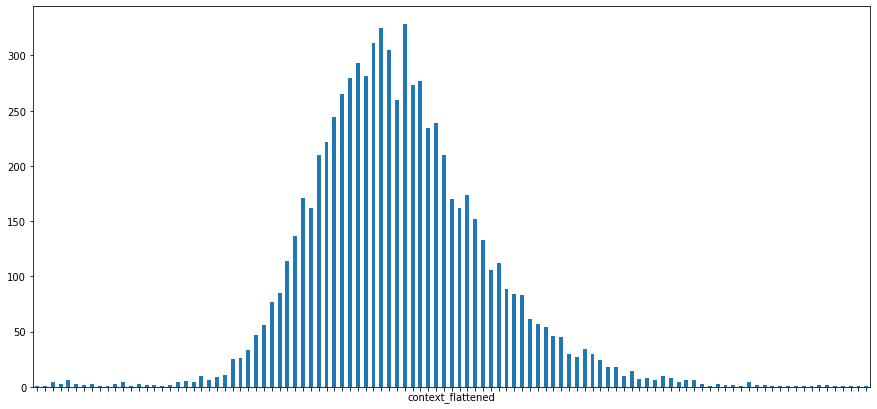

In [65]:
# distribution of number of context sentences
plot = num_of_context_sentences.plot(kind = 'bar', figsize=(15, 7))
plt.xticks(rotation=0)                                    # show label text horizontally
plt.setp(plot.axes.get_xticklabels(), visible=False)      # hide all labels
plt.setp(plot.axes.get_xticklabels()[::5], visible=True)  # set every 5 labels visible
plt.show() 

#### answer

In [66]:
dev_question_df.answer = dev_question_df.answer.map(_normalize_text)  # apply _normalize_text(answer)  

In [67]:
dev_question_df.answer.str.split(' ').str.len().describe()  # statistic of number of words in the answer

count    7405.000000
mean        2.360837
std         1.659080
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        28.000000
Name: answer, dtype: float64

In [68]:
grouped = dev_question_df.groupby(dev_question_df.answer.str.split(' ').str.len())
num_of_answer_words = grouped.size()  # count of each 
num_of_answer_words

answer
1     2441
2     2403
3     1442
4      577
5      247
6      103
7       71
8       44
9       20
10      12
11      11
12      13
13       6
14       5
15       5
16       2
17       1
22       1
28       1
dtype: int64

In [69]:
# number of questions with answer 'yes'
dev_question_df.loc[dev_question_df['answer'] == 'yes'].shape[0]

225

In [70]:
# number of comparison questions with answer 'yes'
dev_question_df.loc[(dev_question_df['answer'] == 'yes') & (dev_question_df['type'] == 'comparison')].shape[0]

225

In [71]:
# number of questions with answer 'no'
dev_question_df.loc[dev_question_df['answer'] == 'no'].shape[0]

233

In [72]:
# number of comparison questions with answer 'no'
dev_question_df.loc[(dev_question_df['answer'] == 'no') & (dev_question_df['type'] == 'comparison')].shape[0]

233

questions with answer yes/no are all comparison questions, and (1487-225-233) = 69.2% comparison questions have span answers 

In [73]:
# dev_question_df["normalized_answer_in_context"] = dev_question_df.apply(lambda row: row['answer'] in row['context_joint'], axis=1)

In [74]:
dev_question_df['normalized_answer_in_context'] = dev_question_df.apply(lambda row:  findWord(row['answer'], row['context_joint']) == True , axis = 1)

In [75]:
dev_question_df.normalized_answer_in_context.describe()

count     7405
unique       2
top       True
freq      7191
Name: normalized_answer_in_context, dtype: object

7191 questions' answer in the context, 7405-7191 = 214 questions' answer are not in the context

In [76]:
dev_question_df.loc[(dev_question_df['normalized_answer_in_context'] == False) & (dev_question_df['answer'] != 'yes') & (dev_question_df['answer'] != 'no') & (dev_question_df['answer'] != '')]

,_id,answer,question,supporting_facts,context,type,level,context_flattened,context_joint,normalized_answer_in_context


In [77]:
dev_question_df.loc[(dev_question_df['normalized_answer_in_context'] == False)].answer.describe()

count     214
unique      2
top       yes
freq      212
Name: answer, dtype: object

In [78]:
dev_question_df.loc[(dev_question_df['normalized_answer_in_context'] == False) & (dev_question_df['answer'] != 'yes') & (dev_question_df['answer'] != 'no')].answer.describe()

count     2
unique    1
top        
freq      2
Name: answer, dtype: object

#### supporting facts

In [79]:
dev_question_df['invalid_supporting_facts_ids'] = dev_question_df.apply(lambda row: True in [sp_idx >= len(dict(row['context'])[sp_t]) for (sp_t, sp_idx) in row['supporting_facts']], axis = 1)

In [80]:
dev_question_df['invalid_supporting_facts_ids'].describe()

count      7405
unique        2
top       False
freq       7404
Name: invalid_supporting_facts_ids, dtype: object

1 questions have at least a supporting fact id out of range. That is, supporting fact id >= total num of sentence in the paragraph

In [81]:
dev_question_df.loc[dev_question_df['invalid_supporting_facts_ids']==True]

,_id,answer,question,supporting_facts,context,type,level,context_flattened,context_joint,normalized_answer_in_context,invalid_supporting_facts_ids
5059,5ae61bfd5542992663a4f261,swingman,Which teams did Jimmy Butler play and what rol...,"[[Shooting guard, 4], [Shooting guard, 5], [Ji...","[[Jimmy Butler (actor), [Jimmy Butler (Februar...",bridge,hard,"[Jimmy Butler (actor), Jimmy Butler (February ...",jimmy butler actor jimmy butler february 20 19...,True,True


In [82]:
# print(dev_question_df.iloc[514].context[7])
# len(dev_question_df.iloc[514].context[7])

In [83]:
dev_question_df['supporting_fact_text'] = dev_question_df.apply(lambda row: [_normalize_text(dict(row['context'])[sp_t][sp_idx]) for (sp_t, sp_idx) in row['supporting_facts'] if(sp_idx < len(dict(row['context'])[sp_t])) ], axis = 1)

In [84]:
dev_question_df.head(3)

,_id,answer,question,supporting_facts,context,type,level,context_flattened,context_joint,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text
0,5a8b57f25542995d1e6f1371,yes,Were Scott Derrickson and Ed Wood of the same ...,"[[Scott Derrickson, 0], [Ed Wood, 0]]","[[Ed Wood (film), [Ed Wood is a 1994 American ...",comparison,hard,"[Ed Wood (film), Ed Wood is a 1994 American bi...",ed wood film ed wood is 1994 american biograph...,False,False,[scott derrickson born july 16 1966 is america...
1,5a8c7595554299585d9e36b6,chief of protocol,What government position was held by the woman...,"[[Kiss and Tell (1945 film), 0], [Shirley Temp...","[[Meet Corliss Archer, [Meet Corliss Archer, a...",bridge,hard,"[Meet Corliss Archer, Meet Corliss Archer, a p...",meet corliss archer meet corliss archer progra...,True,False,[kiss and tell is 1945 american comedy film st...
2,5a85ea095542994775f606a8,animorphs,"What science fantasy young adult series, told ...","[[The Hork-Bajir Chronicles, 0], [The Hork-Baj...","[[Andre Norton Award, [The Andre Norton Award ...",bridge,hard,"[Andre Norton Award, The Andre Norton Award fo...",andre norton award andre norton award for youn...,True,False,[horkbajir chronicles is second companion book...


In [85]:
# add a column to count the number of supporting facts
dev_question_df['num_of_supporting_facts'] = dev_question_df.supporting_fact_text.str.len()

In [86]:
# Distribution of number of supporting facts
dev_question_df.num_of_supporting_facts.describe()

count    7405.000000
mean        2.431330
std         0.711328
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         8.000000
Name: num_of_supporting_facts, dtype: float64

In [87]:
# Distribution of number of supporting facts
grouped = dev_question_df.groupby(['num_of_supporting_facts'])
num_of_supporting_facts_counts = grouped.size()  # count of each 
num_of_supporting_facts_counts

num_of_supporting_facts
2    4990
3    1775
4     536
5      80
6      14
7       9
8       1
dtype: int64

In [88]:
# check thoese questions with more than 8 supportiing facts
dev_question_df.loc[dev_question_df.num_of_supporting_facts == 8]

,_id,answer,question,supporting_facts,context,type,level,context_flattened,context_joint,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text,num_of_supporting_facts
5262,5abab18d55429901930fa89e,lola dee,"The man Tony Bennet called ""The Father of Rock...","[[Lola Dee, 0], [Lola Dee, 1], [Lola Dee, 2], ...","[[Peter Clack, [Peter Clack is an Australian d...",bridge,hard,"[Peter Clack, Peter Clack is an Australian dru...",peter clack peter clack is australian drummer ...,True,False,[lola dee is american singer and recording art...,8


In [89]:
# add a column: whether each supporting fact contains the answer string or not
dev_question_df['normalized_answer_in_supporting_fact'] = dev_question_df.apply(lambda row: [ findWord(row['answer'], f) == True for f in row['supporting_fact_text']], axis = 1)
dev_question_df['normalized_answer_in_supporting_fact']

0                          [False, False]
1                    [False, False, True]
2       [True, False, False, True, False]
3                          [False, False]
4                           [False, True]
                      ...                
7400                  [False, True, True]
7401                         [True, True]
7402                       [False, False]
7403                       [False, False]
7404                        [False, True]
Name: normalized_answer_in_supporting_fact, Length: 7405, dtype: object

In [90]:
dev_question_df.head(3)

,_id,answer,question,supporting_facts,context,type,level,context_flattened,context_joint,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text,num_of_supporting_facts,normalized_answer_in_supporting_fact
0,5a8b57f25542995d1e6f1371,yes,Were Scott Derrickson and Ed Wood of the same ...,"[[Scott Derrickson, 0], [Ed Wood, 0]]","[[Ed Wood (film), [Ed Wood is a 1994 American ...",comparison,hard,"[Ed Wood (film), Ed Wood is a 1994 American bi...",ed wood film ed wood is 1994 american biograph...,False,False,[scott derrickson born july 16 1966 is america...,2,"[False, False]"
1,5a8c7595554299585d9e36b6,chief of protocol,What government position was held by the woman...,"[[Kiss and Tell (1945 film), 0], [Shirley Temp...","[[Meet Corliss Archer, [Meet Corliss Archer, a...",bridge,hard,"[Meet Corliss Archer, Meet Corliss Archer, a p...",meet corliss archer meet corliss archer progra...,True,False,[kiss and tell is 1945 american comedy film st...,3,"[False, False, True]"
2,5a85ea095542994775f606a8,animorphs,"What science fantasy young adult series, told ...","[[The Hork-Bajir Chronicles, 0], [The Hork-Baj...","[[Andre Norton Award, [The Andre Norton Award ...",bridge,hard,"[Andre Norton Award, The Andre Norton Award fo...",andre norton award andre norton award for youn...,True,False,[horkbajir chronicles is second companion book...,5,"[True, False, False, True, False]"


In [91]:
# questions that none of its supporting facts contains the answer string
# that is, rows that dev_question_df['supporting_fact_contain_answer'] is a list of false
dev_question_df[dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x)))] 

,_id,answer,question,supporting_facts,context,type,level,context_flattened,context_joint,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text,num_of_supporting_facts,normalized_answer_in_supporting_fact
0,5a8b57f25542995d1e6f1371,yes,Were Scott Derrickson and Ed Wood of the same ...,"[[Scott Derrickson, 0], [Ed Wood, 0]]","[[Ed Wood (film), [Ed Wood is a 1994 American ...",comparison,hard,"[Ed Wood (film), Ed Wood is a 1994 American bi...",ed wood film ed wood is 1994 american biograph...,False,False,[scott derrickson born july 16 1966 is america...,2,"[False, False]"
3,5adbf0a255429947ff17385a,no,Are the Laleli Mosque and Esma Sultan Mansion ...,"[[Laleli Mosque, 0], [Esma Sultan Mansion, 0]]","[[Esma Sultan (daughter of Abdülaziz), [Esma S...",comparison,hard,"[Esma Sultan (daughter of Abdülaziz), Esma Sul...",esma sultan daughter of abdülaziz esma sultan ...,True,False,[laleli mosque turkish laleli camii or tulip m...,2,"[False, False]"
9,5a8db19d5542994ba4e3dd00,yes,Are Local H and For Against both from the Unit...,"[[Local H, 0], [For Against, 0]]","[[Mendocino County GMO Ban, [Mendocino County,...",comparison,hard,"[Mendocino County GMO Ban, Mendocino County, C...",mendocino county gmo ban mendocino county cali...,False,False,[local h is american rock band originally form...,2,"[False, False]"
17,5ab29c24554299449642c932,yes,Are Giuseppe Verdi and Ambroise Thomas both Op...,"[[Giuseppe Verdi, 0], [Ambroise Thomas, 0]]","[[Bernhard Bötel, [Bernhard Bötel (1883–1953) ...",comparison,hard,"[Bernhard Bötel, Bernhard Bötel (1883–1953) wa...",bernhard bötel bernhard bötel 1883–1953 was ge...,False,False,[giuseppe fortunino francesco verdi 9 or 10 oc...,2,"[False, False]"
27,5abd259d55429924427fcf1a,yes,"Are both Dictyosperma, and Huernia described a...","[[Dictyosperma, 0], [Huernia, 0]]","[[Dictyosperma, [Dictyosperma is a monotypic g...",comparison,hard,"[Dictyosperma, Dictyosperma is a monotypic gen...",dictyosperma dictyosperma is monotypic genus o...,False,False,[dictyosperma is monotypic genus of flowering ...,2,"[False, False]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7339,5ae3d0bb5542990afbd1e1e5,yes,"are Dee Dee Ramone and Alex Band both singers,...","[[Dee Dee Ramone, 0], [Alex Band, 0]]","[[The Ramainz, [The Ramainz were a U.S. tribut...",comparison,hard,"[The Ramainz, The Ramainz were a U.S. tribute ...",ramainz ramainz were us tribute band to ramone...,False,False,[douglas glenn colvin september 18 1951 – june...,2,"[False, False]"
7349,5a7fe0b55542994857a76818,no,"Are The Maine and Black both from Tempe, Arizona?","[[The Maine (band), 0], [Black (Bangladeshi ba...","[[Arizona State University Tempe campus, [Ariz...",comparison,hard,"[Arizona State University Tempe campus, Arizon...",arizona state university tempe campus arizona ...,True,False,[maine is american rock band from tempe arizon...,2,"[False, False]"
7373,5ab8736455429916710eb058,yes,Are Yut and Tsuro both board games?,"[[Yut, 0], [Tsuro, 0]]","[[Days of Wonder, [Days of Wonder is a board g...",comparison,hard,"[Days of Wonder, Days of Wonder is a board gam...",days of wonder days of wonder is board game pu...,False,False,[yut nori also known as yunnori nyout and yoot...,2,"[False, False]"
7402,5a8173fa554299260e20a28e,yes,Are Billy and Barak both breeds of scenthound?...,"[[Bosnian Coarse-haired Hound, 0], [Billy (dog...","[[Styrian Coarse-haired Hound, [The Styrian Co...",comparison,hard,"[Styrian Coarse-haired Hound, The Styrian Coar...",styrian coarsehaired hound styrian coarsehaire...,False,False,[bosnian coarsehaired hound or bosanski oštrod...,2,"[False, False]"


According to the results, there are 341 such questions that the answer string is not in any of the supporting facts.

In [92]:
# questions that none of its supporting facts contains the answer string, and its answer is neither 'yes' nor 'no'
dev_question_df.loc[dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x))) & (dev_question_df['answer'] != 'yes') & (dev_question_df['answer'] != 'no') & (dev_question_df['answer'] != '') ].shape[0]

4

In [93]:
dev_question_df.loc[dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x))) & (dev_question_df['answer'] != 'yes') & (dev_question_df['answer'] != 'no') & (dev_question_df['answer'] != '') ]

,_id,answer,question,supporting_facts,context,type,level,context_flattened,context_joint,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text,num_of_supporting_facts,normalized_answer_in_supporting_fact
289,5a7555215542996c70cfaee1,hey pa theres goat on roof,"Which came to market first, ""Hey Pa! There's a...","[[Hey Pa! There's a Goat on the Roof, 1], [Pol...","[[Pashmina, [Pashmina is a fine type of cashme...",comparison,hard,"[Pashmina, Pashmina is a fine type of cashmere...",pashmina pashmina is fine type of cashmere woo...,True,False,[theres goat on roof was childrens board game ...,2,"[False, False]"
520,5abdd08d5542991f6610604c,guardians of galaxy vol 2,Which movie directed by James Gunn portrayed t...,"[[Ego the Living Planet, 2], [Guardians of the...","[[Paul Williams (The Young and the Restless), ...",bridge,hard,"[Paul Williams (The Young and the Restless), P...",paul williams young and restless paul williams...,True,False,[ego is portrayed by kurt russell in guardians...,2,"[False, False]"
1785,5adde6535542990dbb2f7ef9,hail hail rock n roll,"Which documentary was filmed first, Almost Sun...","[[Almost Sunrise, 0], [Hail! Hail! Rock 'n' Ro...","[[Almost Sunrise, [Almost Sunrise is a 2016 Am...",comparison,hard,"[Almost Sunrise, Almost Sunrise is a 2016 Amer...",almost sunrise almost sunrise is 2016 american...,True,False,[almost sunrise is 2016 american documentary f...,2,"[False, False]"
2211,5ab4b9f75542990594ba9ca4,people and carnabeats,Who covered the song I Love You by Chris Write?,"[[I Love You (The Zombies song), 0], [I Love Y...","[[Spontaneous Combustion (album), [Spontaneous...",bridge,hard,"[Spontaneous Combustion (album), Spontaneous C...",spontaneous combustion album spontaneous combu...,True,False,[i love you is 1965 song by zombies written by...,3,"[False, False, False]"


According to the results, there are only 4 questions that the answer string is not in any of the supporting facts and the answer is not 'yes', 'no', or ''.
This caused by 
    - answer in sp title
    - answer cross sp sentences.

[289]
- answer: hey pa theres goat on roof
- sp contains:
    - theres goat on roof
- sp tilte:
    - Hey Pa! There's a Goat on the Roof
    
[2211]
- answr: people and carnabeats
- sp contains:
    - which was covered by people
    - and carnabeats and by several other artists including foreign translations



In [94]:
# how many supporting facts contains the answer string, that is, the count of 'True'
dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)).describe()

count    7405.00000
mean        1.12181
std         0.46372
min         0.00000
25%         1.00000
50%         1.00000
75%         1.00000
max         4.00000
Name: normalized_answer_in_supporting_fact, dtype: float64

In [95]:
grouped = dev_question_df.groupby(dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)))
num_of_supporting_fact_contain_answer = grouped.size()  # count of each 
num_of_supporting_fact_contain_answer

normalized_answer_in_supporting_fact
0     341
1    5875
2    1140
3      44
4       5
dtype: int64

In [96]:
# check thoese questions with 5 supporting facts contain the answer
dev_question_df.loc[dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)) == 5]

,_id,answer,question,supporting_facts,context,type,level,context_flattened,context_joint,normalized_answer_in_context,invalid_supporting_facts_ids,supporting_fact_text,num_of_supporting_facts,normalized_answer_in_supporting_fact


In [97]:
dev_question_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405 entries, 0 to 7404
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   _id                                   7405 non-null   object
 1   answer                                7405 non-null   object
 2   question                              7405 non-null   object
 3   supporting_facts                      7405 non-null   object
 4   context                               7405 non-null   object
 5   type                                  7405 non-null   object
 6   level                                 7405 non-null   object
 7   context_flattened                     7405 non-null   object
 8   context_joint                         7405 non-null   object
 9   normalized_answer_in_context          7405 non-null   bool  
 10  invalid_supporting_facts_ids          7405 non-null   bool  
 11  supporting_fact_text          

## Reduced context   (20210305)

### Train_reduced_context 

In [96]:
with open('/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/hotpot_train_reduced_context.json') as json_file:      
    data = json_file.readlines()
    data = list(map(json.loads, data))    
train_reduced_context_df = pd.json_normalize(data[0])
 
del data
import gc
gc.collect()

0

In [97]:
train_reduced_context_df.head(3)

,supporting_facts,level,question,context,answer,_id,type,question_phrases,paras_phrases,common_phrases,path_phrases,extended_phrases,reduced_context,kept_para_sent
0,"[[First for Women, 0]]",medium,Which magazine was started first Arthur's Maga...,"[[Radio City (Indian radio station), [Radio Ci...",Arthur's Magazine,5a7a06935542990198eaf050,comparison,"[[first arthurs magazine, 0.3102452893989036],...","[[[['radio city indian radio station', 0.34992...","[woman, magazine, first]","[woman, magazine, first]","[woman, magazine, first, first arthurs, first ...","[[Radio City (Indian radio station), [ It broa...","[[1], [1, 2], [2], [0, 1, 2], [0, 1, 3], [2], ..."
1,"[[Oberoi family, 0], [The Oberoi Group, 0]]",medium,The Oberoi family is part of a hotel company t...,"[[Ritz-Carlton Jakarta, [The Ritz-Carlton Jaka...",Delhi,5a879ab05542996e4f30887e,bridge,"[[hotel company, 0.2213744591115701], [head of...","[[[['ritzcarlton jakarta', 0.4330127018922193]...","[head office, oberoi, hotel company, oberoi fa...","[head office, oberoi, hotel company, oberoi gr...","[head office, oberoi, hotel company, oberoi gr...","[[Oberoi family, [The Oberoi family is an Indi...","[[0], [2], [0, 4], [0], [1]]"
2,"[[Milhouse Van Houten, 0]]",hard,Musician and satirist Allie Goertz wrote a son...,"[[Lisa Simpson, [Lisa Marie Simpson is a ficti...",President Richard Nixon,5a8d7341554299441c6b9fe5,bridge,"[[satirist allie goertz, 0.20768020626775763],...","[[[['lisa simpson', 0.4330127018922193]], [['a...","[matt groening, song, simpsons, allie goertz]","[matt groening, song, los angeles reader, simp...","[matt groening, song, los angeles reader, simp...","[[Lisa Simpson, [ Cartoonist Matt Groening cre...","[[3], [2], [2], [3], [0], [0, 7], [2], [0], [4..."


In [98]:
train_reduced_context_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90447 entries, 0 to 90446
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   supporting_facts  90447 non-null  object
 1   level             90447 non-null  object
 2   question          90447 non-null  object
 3   context           90447 non-null  object
 4   answer            90447 non-null  object
 5   _id               90447 non-null  object
 6   type              90447 non-null  object
 7   question_phrases  90447 non-null  object
 8   paras_phrases     90447 non-null  object
 9   common_phrases    90447 non-null  object
 10  path_phrases      90447 non-null  object
 11  extended_phrases  90447 non-null  object
 12  reduced_context   90447 non-null  object
 13  kept_para_sent    90447 non-null  object
dtypes: object(14)
memory usage: 9.7+ MB


#### reduced Context 

In [99]:
train_joint_df = train_question_df.join(train_reduced_context_df, rsuffix='_reduced_context')
train_joint_df = train_joint_df.loc[:, ['_id', 'question', 'answer', 'level', 'type', 'context', 'supporting_facts', 'reduced_context', 'supporting_facts_reduced_context', 'question_phrases', 'paras_phrases', 'common_phrases', 'path_phrases', 'extended_phrases', 'kept_para_sent']]

In [100]:
train_joint_df.iloc[1]

_id                                                          5a879ab05542996e4f30887e
question                            The Oberoi family is part of a hotel company t...
answer                                                                          delhi
level                                                                          medium
type                                                                           bridge
context                             [[Ritz-Carlton Jakarta, [The Ritz-Carlton Jaka...
supporting_facts                          [[Oberoi family, 0], [The Oberoi Group, 0]]
reduced_context                     [[Oberoi family, [The Oberoi family is an Indi...
supporting_facts_reduced_context          [[Oberoi family, 0], [The Oberoi Group, 0]]
question_phrases                    [[hotel company, 0.2213744591115701], [head of...
paras_phrases                       [[[['ritzcarlton jakarta', 0.4330127018922193]...
common_phrases                      [head office, ober

In [101]:
train_joint_df['reduced_context_joint'] = train_joint_df['reduced_context'].map(lambda x: " ".join(list(flatten(x)) ))
train_joint_df['reduced_context_joint'] = train_joint_df['reduced_context_joint'].map(_normalize_text)  

In [102]:
train_joint_df['reduced_context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

count    90447.000000
mean        18.877464
std          9.125716
min          0.000000
25%         13.000000
50%         19.000000
75%         25.000000
max         75.000000
Name: reduced_context, dtype: float64

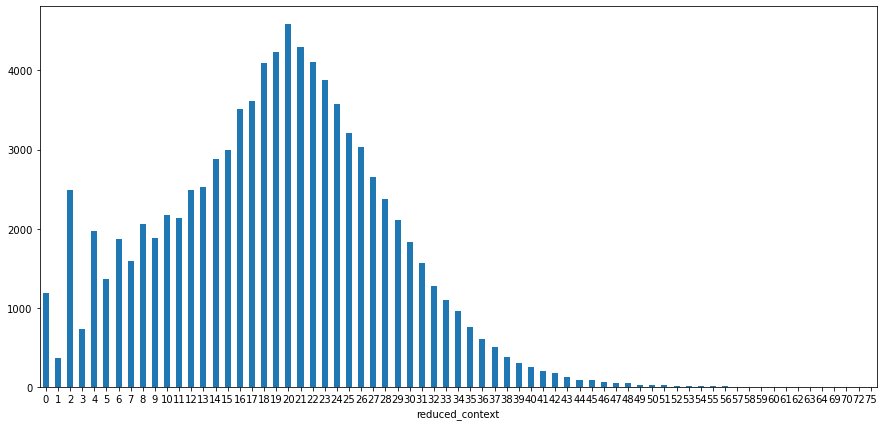

In [103]:
grouped = train_joint_df.groupby(train_joint_df['reduced_context'].map(lambda x: list(flatten(x)) ).str.len())
num_of_context_sentences = grouped.size()  # count of each  

# distribution of number of context sentences
plot = num_of_context_sentences.plot(kind = 'bar', figsize=(15, 7))
plt.xticks(rotation=0)                                    # show label text horizontally 
plt.show() 

#### answer

In [104]:
train_joint_df['normalized_answer_in_reduced_context'] = train_joint_df.apply(lambda row:  findWord(row['answer'], row['reduced_context_joint']) == True , axis = 1)

In [105]:
train_joint_df.normalized_answer_in_reduced_context.describe()

count     90447
unique        2
top        True
freq      63793
Name: normalized_answer_in_reduced_context, dtype: object

63793 questions' answer in the context, 90447-63793 = 26654 questions' answer are not in the reduced context

In [106]:
train_joint_df.loc[(train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no')].shape[0]

66935

In [107]:
train_joint_df.loc[(train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no') | (train_joint_df['answer'] == '')].shape[0]

66942

In [108]:
train_joint_df.loc[(train_joint_df['normalized_answer_in_reduced_context'] == False) & (train_joint_df['answer'] != 'yes') & (train_joint_df['answer'] != 'no') & (train_joint_df['answer'] != '')].shape[0]

23505

In [109]:
train_joint_df.loc[train_joint_df['answer'] == ''].shape[0]

7

#### supporting facts

In [110]:
# Distribution of number of supporting facts in reduced_context
train_joint_df['num_of_sp_in_reduced_context'] = train_joint_df['supporting_facts_reduced_context'].map(lambda x: len(x))
grouped = train_joint_df.groupby(['num_of_sp_in_reduced_context'])
num_of_sp_in_reduced_context_counts = grouped.size()  # count of each 
num_of_sp_in_reduced_context_counts

num_of_sp_in_reduced_context
0    10412
1    30195
2    40172
3     8274
4     1285
5       93
6       14
7        2
dtype: int64

In [111]:
# ratio of supporting facts remained in the reduced context 
train_joint_df['sp_in_reduced_context_ratio'] = train_joint_df.apply(lambda row: len(row['supporting_facts_reduced_context']) / len(row['supporting_facts'])  , axis=1)

#train_joint_df['sp_in_reduced_context'].map(lambda x: sum(x) / len(x)) 
train_joint_df['sp_in_reduced_context_ratio']

0        0.500000
1        1.000000
2        0.250000
3        0.000000
4        0.000000
           ...   
90442    0.500000
90443    0.666667
90444    0.000000
90445    0.500000
90446    1.000000
Name: sp_in_reduced_context_ratio, Length: 90447, dtype: float64

In [112]:
train_joint_df['sp_in_reduced_context_ratio'].describe()

count    90447.000000
mean         0.660098
std          0.337404
min          0.000000
25%          0.500000
50%          0.666667
75%          1.000000
max          1.000000
Name: sp_in_reduced_context_ratio, dtype: float64

In [180]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))].apply(lambda row: len(row['supporting_facts_reduced_context']) / len(row['supporting_facts'])  , axis=1).describe()

count    66872.000000
mean         0.780051
std          0.277019
min          0.000000
25%          0.500000
50%          1.000000
75%          1.000000
max          1.000000
dtype: float64

In [183]:
# for questions whose answer in reduced_context, the ratio of supporting facts remained in the reduced context
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))].apply(lambda row: len(row['supporting_facts_reduced_context']) / len(row['supporting_facts'])  , axis=1).head(10)

1     1.000000
2     0.250000
5     0.333333
6     0.500000
7     0.500000
8     1.000000
13    1.000000
14    1.000000
15    0.600000
18    0.500000
dtype: float64

In [184]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))].iloc[5]

_id                                                              5a7d0db955429909bec76924
question                                The Dutch-Belgian television series that "Hous...
answer                                                                               2006
level                                                                              medium
type                                                                               bridge
context                                 [[House of Anubis, [House of Anubis is a myste...
supporting_facts                             [[House of Anubis, 0], [Het Huis Anubis, 1]]
reduced_context                         [[House of Anubis, [House of Anubis is a myste...
supporting_facts_reduced_context             [[House of Anubis, 0], [Het Huis Anubis, 1]]
question_phrases                        [[dutchbelgian television series, 0.2327723121...
paras_phrases                           [[[['house', 0.3333333333333333], ['anubis', 0...
common_phr

In [114]:
# reduced_context contains the answer, even though does not contain any supporting fact
train_joint_df.loc[(train_joint_df.num_of_sp_in_reduced_context == 0) & (train_joint_df.normalized_answer_in_reduced_context == True)].shape[0]

1774

In [115]:
train_joint_df.loc[(train_joint_df.num_of_sp_in_reduced_context == 0) & (train_joint_df.normalized_answer_in_reduced_context == True)].head(3)

,_id,question,answer,level,type,context,supporting_facts,reduced_context,supporting_facts_reduced_context,question_phrases,paras_phrases,common_phrases,path_phrases,extended_phrases,kept_para_sent,reduced_context_joint,normalized_answer_in_reduced_context,num_of_sp_in_reduced_context,sp_in_reduced_context_ratio
27,5ae3918b5542994393b9e709,Were Pavel Urysohn and Leonid Levin known for ...,no,medium,comparison,"[[Leonid Ramzin, [Leonid Konstantinovich Ramzi...","[[Pavel Urysohn, 0], [Leonid Levin, 0]]","[[Kate Dillon Levin, [Kate Dillon Levin (born ...",[],"[[leonid levin, 0.23639070780118254], [same ty...","[[[['leonid ramzin', 0.4330127018922193], ['le...","[leonid levin, work, pavel urysohn]","[many mass medium outlet, leonid levin, work, ...","[many mass medium outlet, leonid levin, work, ...","[[0, 1], [2], [], [], [1]]",kate dillon levin kate dillon levin born march...,True,0,0.0
86,5ab9672655429970cfb8eabd,Which industry do Richard Hawley and Chicago's...,rock band,easy,comparison,"[[Late Night Final, [Late Night Final is the s...","[[Catherine (alternative rock band), 0], [Rich...","[[Late Night Final, [Late Night Final is the s...",[],"[[richard hawley, 0.26763402048270435], [chica...","[[[['late night', 0.35355339059327373]], [['mi...",[richard hawley],[richard hawley],"[richard hawley, chicagos catherine, industry]","[[0], [0], [0], [], [0], [0], [2], [1], [0]]",late night final late night final is second st...,True,0,0.0
225,5abaebab55429939ce03dd66,In between Memphis International Airport and S...,memphis international airport,medium,comparison,"[[Southwest Georgia Regional Airport, [Southwe...","[[Memphis International Airport, 0], [Southwes...","[[FedEx Express Flight 1406, [FedEx Express Fl...",[],"[[memphis international airport, 0.25978557794...","[[[['southwest georgia regional airport', 0.37...","[one, memphis international airport, tennessee...","[one, tennessee, georgia, airport, memphis int...","[one, tennessee, georgia, airport, memphis int...","[[0], [], [0], [2, 5], [2], [0, 1], [0], [2, 3]]",fedex express flight 1406 fedex express flight...,True,0,0.0


In [116]:
train_joint_df.loc[train_joint_df._id=='5ab9672655429970cfb8eabd'].supporting_facts.values.tolist()

[[['Catherine (alternative rock band)', 0], ['Richard Hawley', 0]]]

In [117]:
train_joint_df.loc[train_joint_df._id=='5ab9672655429970cfb8eabd'].reduced_context.values.tolist()

[[['Late Night Final',
   ['Late Night Final is the second studio album (and first full-length album after the mini-album "Richard Hawley" released six months earlier) from musician Richard Hawley, released in the UK in October 2001 by Setanta Records.']],
  ["Lady's Bridge (album)",
   ["Lady's Bridge is the fifth studio album from musician Richard Hawley, released on 20 August 2007 in the UK and on 9 October 2007 in the US."]],
  ["Standing at the Sky's Edge",
   ["Standing at the Sky's Edge is the seventh studio album from English musician Richard Hawley, released in the UK on 7 May 2012 and in the US on 28 August 2012."]],
  ['Richard Hawley', []],
  ["Truelove's Gutter",
   ["Truelove's Gutter is the sixth studio album from musician Richard Hawley, released on 21 September 2009 in the UK and on 22 September 2009 in the US."]],
  ['Lowedges',
   ['Lowedges is the third studio album from musician Richard Hawley.']],
  ['A Heavy Nite With...',
   [' It has been alleged that Jason Buc

In [118]:
train_joint_df['sp_text_reduced_context'] = train_joint_df.apply(lambda row: [_normalize_text(dict(row['reduced_context'])[sp_t][sp_idx]) for (sp_t, sp_idx) in row['supporting_facts_reduced_context'] if(sp_idx < len(dict(row['reduced_context'])[sp_t])) ], axis = 1)

train_joint_df['sp_text_reduced_context']  

0        [first for women is womans magazine published ...
1        [oberoi family is indian family that is famous...
2        [milhouse mussolini van houten is fictional ch...
3                                                       []
4                                                       []
                               ...                        
90442    [she is daughter of actor bert remsen and cast...
90443    [liberty tree mall is shopping mall in danvers...
90444                                                   []
90445    [mv wilhelm gustloff was german military trans...
90446    [vietnam national cricket team represents viet...
Name: sp_text_reduced_context, Length: 90447, dtype: object

In [119]:
train_joint_df['normalized_answer_in_reduced_sp_text'] = train_joint_df.apply(lambda row: any([ findWord(row['answer'], f) == True for f in row['sp_text_reduced_context']]), axis = 1)
train_joint_df['normalized_answer_in_reduced_sp_text']

0        False
1         True
2         True
3        False
4        False
         ...  
90442    False
90443     True
90444    False
90445     True
90446     True
Name: normalized_answer_in_reduced_sp_text, Length: 90447, dtype: bool

In [120]:
train_joint_df.normalized_answer_in_reduced_sp_text.describe()

count     90447
unique        2
top        True
freq      56471
Name: normalized_answer_in_reduced_sp_text, dtype: object

In [121]:
train_joint_df.loc[(train_joint_df['normalized_answer_in_reduced_sp_text'] == False) & (train_joint_df['answer'] != 'yes') & (train_joint_df['answer'] != 'no') & (train_joint_df['answer'] != '')].shape[0]

29511

In [122]:
# reduced_context contain the answer, but the sp in reduced context does not contain the answer
train_joint_df.loc[(train_joint_df.normalized_answer_in_reduced_context == True) & (train_joint_df.normalized_answer_in_reduced_sp_text == False) ].shape[0]

7322

#### Save 
To train longformer on context vs reduced_context, compare run time and performance  
just over the questions has answer in the reduced_context
Thus save file contains only the questions has answer in the reduced_context

In [123]:
train_joint_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90447 entries, 0 to 90446
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   _id                                   90447 non-null  object 
 1   question                              90447 non-null  object 
 2   answer                                90447 non-null  object 
 3   level                                 90447 non-null  object 
 4   type                                  90447 non-null  object 
 5   context                               90447 non-null  object 
 6   supporting_facts                      90447 non-null  object 
 7   reduced_context                       90447 non-null  object 
 8   supporting_facts_reduced_context      90447 non-null  object 
 9   question_phrases                      90447 non-null  object 
 10  paras_phrases                         90447 non-null  object 
 11  common_phrases 

In [124]:
hotpot_reduced_train_df = train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no')) , ['supporting_facts', 'context', 'answer', '_id', 'question']]
hotpot_reduced_train_df.shape[0]

66872

In [125]:
hotpot_reduced_train_df.head(3)

,supporting_facts,context,answer,_id,question
1,"[[Oberoi family, 0], [The Oberoi Group, 0]]","[[Ritz-Carlton Jakarta, [The Ritz-Carlton Jaka...",delhi,5a879ab05542996e4f30887e,The Oberoi family is part of a hotel company t...
2,"[[Allie Goertz, 0], [Allie Goertz, 1], [Allie ...","[[Lisa Simpson, [Lisa Marie Simpson is a ficti...",president richard nixon,5a8d7341554299441c6b9fe5,Musician and satirist Allie Goertz wrote a son...
5,"[[Jonathan Stark (tennis), 0], [Jonathan Stark...","[[Li Na, [Li Na (; ; born 26 February 1982) is...",jonathan stark,5a7e36045542991319bc9440,Which tennis player won more Grand Slam titles...


In [126]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['reduced_context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of reduced_context sentences, including tilte

count    66872.000000
mean        20.457456
std          8.548174
min          1.000000
25%         15.000000
50%         21.000000
75%         26.000000
max         75.000000
Name: reduced_context, dtype: float64

In [127]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['reduced_context_joint'].str.len().describe()  # statistic of number of words in reduced_context

count    66872.00000
mean      1853.78888
std        969.94518
min          5.00000
25%       1174.00000
50%       1744.00000
75%       2421.00000
max       8703.00000
Name: reduced_context_joint, dtype: float64

In [128]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

count    66872.000000
mean        50.471139
std         11.229584
min          4.000000
25%         43.000000
50%         50.000000
75%         56.000000
max        154.000000
Name: context, dtype: float64

In [129]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['context'].map(lambda x: " ".join(list(flatten(x))) ).str.len().describe() # statistic of number of words in the context

count    66872.000000
mean      5604.017451
std       1555.974212
min        197.000000
25%       4581.000000
50%       5496.000000
75%       6499.000000
max      17163.000000
Name: context, dtype: float64

In [130]:
#hotpot_reduced_train_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/context/hotpot_reduced_train.json", orient="records") 

In [131]:
# save file contains only the questions with reduced_context has answer in the reduced_context
hotpot_train_reduced_context_df = train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no')) , ['supporting_facts_reduced_context', 'reduced_context', 'answer', '_id', 'question']] 

hotpot_train_reduced_context_df.rename(columns={'supporting_facts_reduced_context': 'supporting_facts', "reduced_context": "context"}, inplace=True)
hotpot_train_reduced_context_df.shape[0]

66872

In [132]:
#hotpot_train_reduced_context_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/reduced_context/hotpot_reduced_train_reduced_context.json", orient="records") 

### Dev_reduced_context 

In [133]:
with open('/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/hotpot_dev_distractor_reduced_context.json') as json_file:      
    data = json_file.readlines()
    data = list(map(json.loads, data))    
dev_reduced_context_df = pd.json_normalize(data[0])
 
del data
import gc
gc.collect()

16953

In [134]:
dev_reduced_context_df.head(3)

,_id,answer,question,supporting_facts,context,type,level,question_phrases,paras_phrases,common_phrases,path_phrases,extended_phrases,reduced_context,kept_para_sent
0,5a8b57f25542995d1e6f1371,yes,Were Scott Derrickson and Ed Wood of the same ...,"[[Scott Derrickson, 0]]","[[Ed Wood (film), [Ed Wood is a 1994 American ...",comparison,hard,"[[ed wood, 0.2841758924319113], [scott derrick...","[[[['ed wood film', 0.4], ['ed wood', 0.353553...","[ed wood, scott derrickson]","[ed wood, scott derrickson]","[ed wood, scott derrickson, same nationality]","[[Ed Wood (film), [Ed Wood is a 1994 American ...","[[0], [0], [], [0], [0], [3], [2]]"
1,5a8c7595554299585d9e36b6,Chief of Protocol,What government position was held by the woman...,"[[Kiss and Tell (1945 film), 0]]","[[Meet Corliss Archer, [Meet Corliss Archer, a...",bridge,hard,"[[corliss archer, 0.21343307099261227], [film ...","[[[['meet corliss archer', 0.4], ['corliss arc...",[corliss archer],[corliss archer],"[corliss archer, film kiss, woman, government ...","[[Meet Corliss Archer, [Meet Corliss Archer, a...","[[0], [1], [0], [0], [5]]"
2,5a85ea095542994775f606a8,Animorphs,"What science fantasy young adult series, told ...","[[The Hork-Bajir Chronicles, 0], [The Hork-Baj...","[[Andre Norton Award, [The Andre Norton Award ...",bridge,hard,"[[science fantasy young adult series, 0.192038...","[[[['andre norton award', 0.4], ['andre norton...","[first person, companion book, first, story]","[first person, companion book, book, first, st...","[first person, companion book, book, first, st...","[[Victoria Hanley, [ Her first three books, ""T...","[[1], [1, 2], [0, 1, 3, 5], [2, 3], [1], [1], ..."


In [135]:
dev_reduced_context_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405 entries, 0 to 7404
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   _id               7405 non-null   object
 1   answer            7405 non-null   object
 2   question          7405 non-null   object
 3   supporting_facts  7405 non-null   object
 4   context           7405 non-null   object
 5   type              7405 non-null   object
 6   level             7405 non-null   object
 7   question_phrases  7405 non-null   object
 8   paras_phrases     7405 non-null   object
 9   common_phrases    7405 non-null   object
 10  path_phrases      7405 non-null   object
 11  extended_phrases  7405 non-null   object
 12  reduced_context   7405 non-null   object
 13  kept_para_sent    7405 non-null   object
dtypes: object(14)
memory usage: 810.0+ KB


#### Example

In [136]:
dev_joint_df = dev_question_df.join(dev_reduced_context_df, rsuffix='_reduced_context')
dev_joint_df = dev_joint_df.loc[:, ['_id', 'question', 'answer', 'level', 'type', 'context', 'supporting_facts', 'reduced_context', 'supporting_facts_reduced_context', 'question_phrases', 'paras_phrases', 'common_phrases', 'path_phrases', 'extended_phrases', 'kept_para_sent']]

In [137]:
dev_joint_df.iloc[1]

_id                                                          5a8c7595554299585d9e36b6
question                            What government position was held by the woman...
answer                                                              chief of protocol
level                                                                            hard
type                                                                           bridge
context                             [[Meet Corliss Archer, [Meet Corliss Archer, a...
supporting_facts                    [[Kiss and Tell (1945 film), 0], [Shirley Temp...
reduced_context                     [[Meet Corliss Archer, [Meet Corliss Archer, a...
supporting_facts_reduced_context                     [[Kiss and Tell (1945 film), 0]]
question_phrases                    [[corliss archer, 0.21343307099261227], [film ...
paras_phrases                       [[[['meet corliss archer', 0.4], ['corliss arc...
common_phrases                                        

In [138]:
dev_joint_df.iloc[1].question

'What government position was held by the woman who portrayed Corliss Archer in the film Kiss and Tell?'

In [139]:
dev_joint_df.iloc[1].question_phrases

[['corliss archer', 0.21343307099261227],
 ['film kiss', 0.20244191004132744],
 ['woman', 0.1488362798886544],
 ['government position', 0.10321032895191254]]

The pharse extraction is not perfect, *'film'* and *'Kiss and Tell'* will be better.

In [140]:
dev_joint_df.iloc[1].paras_phrases

[[[['meet corliss archer', 0.4],
   ['corliss archer', 0.35355339059327373],
   ['meet', 0.2721655269759087]],
  [['radio golden age', 0.18985858955553894],
   ['corliss archer program', 0.18684782617842577],
   ['corliss archer', 0.15621424412498358],
   ['january 7 1943 september 30 1956', 0.15579934502414455],
   ['september', 0.13357184551206308],
   ['january', 0.12678315856422756]],
  [['nbcs popular date', 0.19198525167644231],
   ['summer replacement', 0.16580379501120182],
   ['cbss answer', 0.1444268279716055],
   ['bob', 0.1364196795586348],
   ['nbc', 0.12360261951351523],
   ['judy', 0.12033112796952505],
   ['1948', 0.12033112796952505],
   ['summer', 0.1191137760776727],
   ['cbss', 0.10134688565547174]],
  [['october 3 1952 june 26 1953', 0.17914880475830236],
   ['june', 0.1534888043994956],
   ['abc', 0.13744661667703784],
   ['cbs', 0.11768707508805853],
   ['october', 0.11618382875642504]],
  [['few 24 episode', 0.17046104059250225],
   ['program', 0.157004257364014

In [141]:
dev_joint_df.iloc[1].common_phrases

['corliss archer']

In [142]:
dev_joint_df.iloc[1].extended_phrases

['corliss archer', 'film kiss', 'woman', 'government position']

In [143]:
dev_joint_df.iloc[1].supporting_facts

[['Kiss and Tell (1945 film)', 0],
 ['Shirley Temple', 0],
 ['Shirley Temple', 1]]

In [144]:
dev_joint_df.iloc[1].supporting_facts_reduced_context

[['Kiss and Tell (1945 film)', 0]]

In [145]:
list(enumerate(dev_joint_df.iloc[1].context))

[(0,
  ['Meet Corliss Archer',
   ["Meet Corliss Archer, a program from radio's Golden Age, ran from January 7, 1943 to September 30, 1956.",
    ' Although it was CBS\'s answer to NBC\'s popular "A Date with Judy", it was also broadcast by NBC in 1948 as a summer replacement for "The Bob Hope Show".',
    ' From October 3, 1952 to June 26, 1953, it aired on ABC, finally returning to CBS.',
    " Despite the program's long run, fewer than 24 episodes are known to exist."]]),
 (1,
  ['Shirley Temple',
   ["Shirley Temple Black (April 23, 1928 – February 10, 2014) was an American actress, singer, dancer, businesswoman, and diplomat who was Hollywood's number one box-office draw as a child actress from 1935 to 1938.",
    ' As an adult, she was named United States ambassador to Ghana and to Czechoslovakia and also served as Chief of Protocol of the United States.']]),
 (2,
  ['Janet Waldo',
   ['Janet Marie Waldo (February 4, 1920 – June 12, 2016) was an American radio and voice actress.'

In [146]:
list(enumerate(dev_joint_df.iloc[1].paras_phrases[6]))

[(0, [['1945 film', 0.30618621784789724], ['1945', 0.2561306370643219]]),
 (1,
  [['1945 american comedy film', 0.21894889843973683],
   ['17yearold shirley temple', 0.20288361698880442],
   ['shirley temple', 0.18093167392553705],
   ['american', 0.14043643876659098],
   ['corliss archer', 0.13926541758372488],
   ['1945', 0.1284893446563067]]),
 (2,
  [['two teenage girl', 0.18751772716956946],
   ['two', 0.12336987307235638],
   ['film', 0.10943881858356827],
   ['boy', 0.10388763207320373],
   ['respective parent', 0.10323638804008303]]),
 (3,
  [['bad influence', 0.2333668624104014],
   ['more problem', 0.22295371890690896],
   ['parent', 0.11409485751150897],
   ['girl', 0.0842239636386126]])]

Even though 'Kiss and Tell (1945 film)' is found based on *'corliss archer'*, and even find the sentence that contains *'shirley temple'*, but it failed to identify *'shirley temple'* as an extended phrase to further explore other sentences that contains *'shirley temple'*. This is mainly because *'Kiss and Tell'* is not recognized in question, and thus *'shirley temple'* is not included in the path when there is only one common phrase.

#### reduced Context 

In [147]:
dev_joint_df['reduced_context_joint'] = dev_joint_df['reduced_context'].map(lambda x: " ".join(list(flatten(x)) ))
dev_joint_df['reduced_context_joint'] = dev_joint_df['reduced_context_joint'].map(_normalize_text)  

In [148]:
dev_joint_df['reduced_context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

count    7405.000000
mean       18.439838
std         9.087830
min         0.000000
25%        12.000000
50%        19.000000
75%        24.000000
max        71.000000
Name: reduced_context, dtype: float64

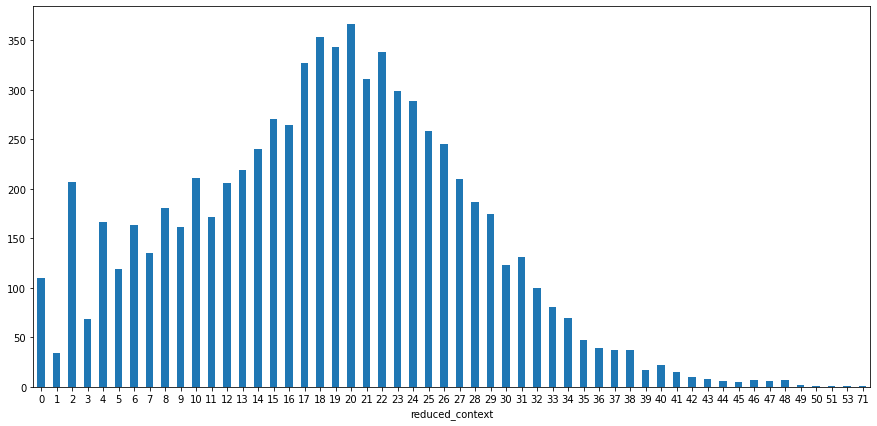

In [149]:
grouped = dev_joint_df.groupby(dev_joint_df['reduced_context'].map(lambda x: list(flatten(x)) ).str.len())
num_of_context_sentences = grouped.size()  # count of each  

# distribution of number of context sentences
plot = num_of_context_sentences.plot(kind = 'bar', figsize=(15, 7))
plt.xticks(rotation=0)                                    # show label text horizontally 
plt.show() 

#### answer

In [150]:
dev_joint_df['normalized_answer_in_reduced_context'] = dev_joint_df.apply(lambda row:  findWord(row['answer'], row['reduced_context_joint']) == True , axis = 1)

In [151]:
dev_joint_df.normalized_answer_in_reduced_context.describe()

count     7405
unique       2
top       True
freq      4824
Name: normalized_answer_in_reduced_context, dtype: object

4824 questions' answer in the context, 7405-4824 = 2581 questions' answer are not in the reduced context

In [152]:
dev_joint_df.loc[(dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no')].shape[0]

5083

In [153]:
dev_joint_df.loc[(dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no') | (dev_joint_df['answer'] == '')].shape[0]

5085

In [154]:
dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no')) ].shape[0]

5075

In [155]:
dev_joint_df.loc[(dev_joint_df['normalized_answer_in_reduced_context'] == False) & (dev_joint_df['answer'] != 'yes') & (dev_joint_df['answer'] != 'no') & (dev_joint_df['answer'] != '')].shape[0]

2320

#### supporting facts

In [156]:
# Distribution of number of supporting facts in reduced_context
dev_joint_df['num_of_sp_in_reduced_context'] = dev_joint_df['supporting_facts_reduced_context'].map(lambda x: len(x))
grouped = dev_joint_df.groupby(['num_of_sp_in_reduced_context'])
num_of_sp_in_reduced_context_counts = grouped.size()  # count of each 
num_of_sp_in_reduced_context_counts

num_of_sp_in_reduced_context
0     976
1    2702
2    2943
3     670
4     105
5       9
dtype: int64

In [157]:
# ratio of supporting facts remained in the reduced context 
dev_joint_df['sp_in_reduced_context_ratio'] = dev_joint_df.apply(lambda row: len(row['supporting_facts_reduced_context']) / len(row['supporting_facts'])  , axis=1)

#dev_joint_df['sp_in_reduced_context'].map(lambda x: sum(x) / len(x)) 
dev_joint_df['sp_in_reduced_context_ratio']

0       0.500000
1       0.333333
2       0.600000
3       0.500000
4       0.500000
          ...   
7400    0.666667
7401    0.500000
7402    1.000000
7403    0.500000
7404    0.500000
Name: sp_in_reduced_context_ratio, Length: 7405, dtype: float64

In [158]:
dev_joint_df['sp_in_reduced_context_ratio'].describe()

count    7405.000000
mean        0.619735
std         0.340262
min         0.000000
25%         0.500000
50%         0.500000
75%         1.000000
max         1.000000
Name: sp_in_reduced_context_ratio, dtype: float64

In [185]:
# for questions whose answer in reduced_context, the ratio of supporting facts remained in the reduced context
dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no'))].apply(lambda row: len(row['supporting_facts_reduced_context']) / len(row['supporting_facts'])  , axis=1).head(10)

0     0.500000
2     0.600000
3     0.500000
4     0.500000
5     1.000000
6     1.000000
7     1.000000
8     0.666667
9     0.500000
10    1.000000
dtype: float64

In [186]:
dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no'))].iloc[5]

_id                                                              5a85b2d95542997b5ce40028
question                                Who was known by his stage name Aladin and hel...
answer                                                                      eenasul fateh
level                                                                                hard
type                                                                               bridge
context                                 [[James P. Comer, [James P. Comer (born James ...
supporting_facts                         [[Eenasul Fateh, 0], [Management consulting, 0]]
reduced_context                         [[James P. Comer, [ Dr. Comer has also served ...
supporting_facts_reduced_context         [[Eenasul Fateh, 0], [Management consulting, 0]]
question_phrases                        [[organization, 0.17863372206830022], [aladin,...
paras_phrases                           [[[['james p comer', 0.4]], [['james pierpont ...
common_phr

In [160]:
# reduced_context contains the answer, even though does not contain any supporting fact
dev_joint_df.loc[(dev_joint_df.num_of_sp_in_reduced_context == 0) & (dev_joint_df.normalized_answer_in_reduced_context == True)].shape[0]

183

In [161]:
dev_joint_df['sp_text_reduced_context'] = dev_joint_df.apply(lambda row: [_normalize_text(dict(row['reduced_context'])[sp_t][sp_idx]) for (sp_t, sp_idx) in row['supporting_facts_reduced_context'] if(sp_idx < len(dict(row['reduced_context'])[sp_t])) ], axis = 1)

dev_joint_df['sp_text_reduced_context']  

0       [scott derrickson born july 16 1966 is america...
1       [kiss and tell is 1945 american comedy film st...
2       [with respect to continuity within series it t...
3       [laleli mosque turkish laleli camii or tulip m...
4       [adriana trigiani is italian american bestsell...
                              ...                        
7400    [coke kahani urdu کوک کہانی‎ is 2012 pakistani...
7401    [canfields diet chocolate fudge soda is zeroca...
7402    [billy is large scenthound originating from ce...
7403    [thinking fellers union local 282 is experimen...
7404    [blackfin is family of 16 or 32bit microproces...
Name: sp_text_reduced_context, Length: 7405, dtype: object

In [162]:
dev_joint_df['normalized_answer_in_reduced_sp_text'] = dev_joint_df.apply(lambda row: any([ findWord(row['answer'], f) == True for f in row['sp_text_reduced_context']]), axis = 1)
dev_joint_df['normalized_answer_in_reduced_sp_text']

0       False
1       False
2       False
3       False
4        True
        ...  
7400     True
7401     True
7402    False
7403    False
7404    False
Name: normalized_answer_in_reduced_sp_text, Length: 7405, dtype: bool

In [163]:
dev_joint_df.normalized_answer_in_reduced_sp_text.describe()

count     7405
unique       2
top       True
freq      4152
Name: normalized_answer_in_reduced_sp_text, dtype: object

In [164]:
dev_joint_df.loc[(dev_joint_df['normalized_answer_in_reduced_sp_text'] == False) & (dev_joint_df['answer'] != 'yes') & (dev_joint_df['answer'] != 'no') & (dev_joint_df['answer'] != '')].shape[0]

2877

In [165]:
dev_joint_df.loc[ (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no') | (dev_joint_df['answer'] == '')].shape[0]

460

In [166]:
dev_joint_df.loc[(dev_joint_df['normalized_answer_in_reduced_sp_text'] == True) & ( (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no') |(dev_joint_df['answer'] == ''))].shape[0]

84

In [167]:
# reduced_context contain the answer, but the sp in reduced context does not contain the answer
dev_joint_df.loc[(dev_joint_df.normalized_answer_in_reduced_context == True) & (dev_joint_df.normalized_answer_in_reduced_sp_text == False) ].shape[0]

672

#### Save 
To train longformer on context vs reduced_context, compare run time and performance  
just over the questions has answer in the reduced_context
Thus save file contains only the questions has answer in the reduced_context

In [168]:
dev_joint_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405 entries, 0 to 7404
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   _id                                   7405 non-null   object 
 1   question                              7405 non-null   object 
 2   answer                                7405 non-null   object 
 3   level                                 7405 non-null   object 
 4   type                                  7405 non-null   object 
 5   context                               7405 non-null   object 
 6   supporting_facts                      7405 non-null   object 
 7   reduced_context                       7405 non-null   object 
 8   supporting_facts_reduced_context      7405 non-null   object 
 9   question_phrases                      7405 non-null   object 
 10  paras_phrases                         7405 non-null   object 
 11  common_phrases   

In [169]:
hotpot_reduced_dev_df = dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no')) , ['supporting_facts', 'context', 'answer', '_id', 'question']]
hotpot_reduced_dev_df.shape[0]

5075

In [170]:
dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no'))]['reduced_context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

count    5075.000000
mean       20.241379
std         8.513192
min         1.000000
25%        15.000000
50%        20.000000
75%        26.000000
max        71.000000
Name: reduced_context, dtype: float64

In [171]:
dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no'))]['reduced_context_joint'].str.len().describe()  # statistic of number of words in reduced_context

count    5075.000000
mean     1845.822069
std       964.777206
min        10.000000
25%      1157.000000
50%      1731.000000
75%      2435.000000
max      7489.000000
Name: reduced_context_joint, dtype: float64

In [172]:
dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no'))]['context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

count    5075.000000
mean       50.923941
std        11.397092
min         4.000000
25%        44.000000
50%        50.000000
75%        57.000000
max       144.000000
Name: context, dtype: float64

In [173]:
dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no'))]['context'].map(lambda x: " ".join(list(flatten(x))) ).str.len().describe() # statistic of number of words in the context

count     5075.000000
mean      5676.258522
std       1569.157603
min        324.000000
25%       4633.500000
50%       5580.000000
75%       6572.000000
max      15413.000000
Name: context, dtype: float64

In [174]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['context'].map(lambda x: " ".join(list(flatten(x))) ).str.len().describe() # statistic of number of words in the context#hotpot_reduced_dev_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/context/hotpot_reduced_dev_distractor.json", orient="records") 

count    66872.000000
mean      5604.017451
std       1555.974212
min        197.000000
25%       4581.000000
50%       5496.000000
75%       6499.000000
max      17163.000000
Name: context, dtype: float64

In [175]:
# save file contains only the questions with reduced_context has answer in the reduced_context
hotpot_dev_reduced_context_df = dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no')) , ['supporting_facts_reduced_context', 'reduced_context', 'answer', '_id', 'question']] 

hotpot_dev_reduced_context_df.rename(columns={'supporting_facts_reduced_context': 'supporting_facts', "reduced_context": "context"}, inplace=True)
hotpot_dev_reduced_context_df.shape[0]

5075

In [176]:
hotpot_dev_reduced_context_detail_df = dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no')) , ['supporting_facts_reduced_context', 'reduced_context', 'answer', '_id', 'question', 'level', 'type', 'question_phrases', 'paras_phrases', 'common_phrases', 'path_phrases', 'extended_phrases', 'kept_para_sent', 'num_of_sp_in_reduced_context', 'sp_in_reduced_context_ratio']] 

hotpot_dev_reduced_context_detail_df.rename(columns={'supporting_facts_reduced_context': 'supporting_facts', "reduced_context": "context"}, inplace=True)
hotpot_dev_reduced_context_detail_df.shape[0]

5075

In [177]:
hotpot_dev_reduced_context_detail_df.iloc[1]

supporting_facts                [[The Hork-Bajir Chronicles, 0], [The Hork-Baj...
context                         [[Victoria Hanley, [ Her first three books, "T...
answer                                                                  animorphs
_id                                                      5a85ea095542994775f606a8
question                        What science fantasy young adult series, told ...
level                                                                        hard
type                                                                       bridge
question_phrases                [[science fantasy young adult series, 0.192038...
paras_phrases                   [[[['andre norton award', 0.4], ['andre norton...
common_phrases                       [first person, companion book, first, story]
path_phrases                    [first person, companion book, book, first, st...
extended_phrases                [first person, companion book, book, first, st...
kept_para_sent  

In [178]:
#hotpot_dev_reduced_context_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/reduced_context/hotpot_reduced_dev_distractor_reduced_context.json", orient="records") 

#hotpot_dev_reduced_context_detail_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/reduced_context/hotpot_reduced_dev_distractor_reduced_context_detail.json", orient="records") 

In [ ]:
from numpy import loadtxt
reduced_context_ratios = loadtxt("graph_reduced_context_ratios.txt", delimiter=",")
reduced_context_ratios_df = pd.DataFrame(reduced_context_ratios)

## Reduced context with Coref and Root of Noun_chunks  (20210403)

## Reduced context with Coref and Root of Noun_chunks, RG, Fuzzy match  (20210405)

### Train_reduced_context 

In [3]:
with open('/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/train_subtasks_out/hotpot_train_reduced_context_coref.json') as json_file:      
    data = json_file.readlines()
    data = list(map(json.loads, data))    
train_coref_reduced_context_df = pd.json_normalize(data[0])
 
del data
import gc
gc.collect()

JSONDecodeError: Expecting value: line 2 column 1 (char 2)

In [ ]:
train_coref_reduced_context_df.head(3)

In [ ]:
train_coref_reduced_context_df.info()

#### reduced Context 

In [99]:
train_joint_df = train_question_df.join(train_reduced_context_df, rsuffix='_reduced_context')
train_joint_df = train_joint_df.loc[:, ['_id', 'question', 'answer', 'level', 'type', 'context', 'supporting_facts', 'reduced_context', 'supporting_facts_reduced_context', 'question_phrases', 'paras_phrases', 'common_phrases', 'path_phrases', 'extended_phrases', 'kept_para_sent']]

In [100]:
train_joint_df.iloc[1]

_id                                                          5a879ab05542996e4f30887e
question                            The Oberoi family is part of a hotel company t...
answer                                                                          delhi
level                                                                          medium
type                                                                           bridge
context                             [[Ritz-Carlton Jakarta, [The Ritz-Carlton Jaka...
supporting_facts                          [[Oberoi family, 0], [The Oberoi Group, 0]]
reduced_context                     [[Oberoi family, [The Oberoi family is an Indi...
supporting_facts_reduced_context          [[Oberoi family, 0], [The Oberoi Group, 0]]
question_phrases                    [[hotel company, 0.2213744591115701], [head of...
paras_phrases                       [[[['ritzcarlton jakarta', 0.4330127018922193]...
common_phrases                      [head office, ober

In [101]:
train_joint_df['reduced_context_joint'] = train_joint_df['reduced_context'].map(lambda x: " ".join(list(flatten(x)) ))
train_joint_df['reduced_context_joint'] = train_joint_df['reduced_context_joint'].map(_normalize_text)  

In [102]:
train_joint_df['reduced_context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

count    90447.000000
mean        18.877464
std          9.125716
min          0.000000
25%         13.000000
50%         19.000000
75%         25.000000
max         75.000000
Name: reduced_context, dtype: float64

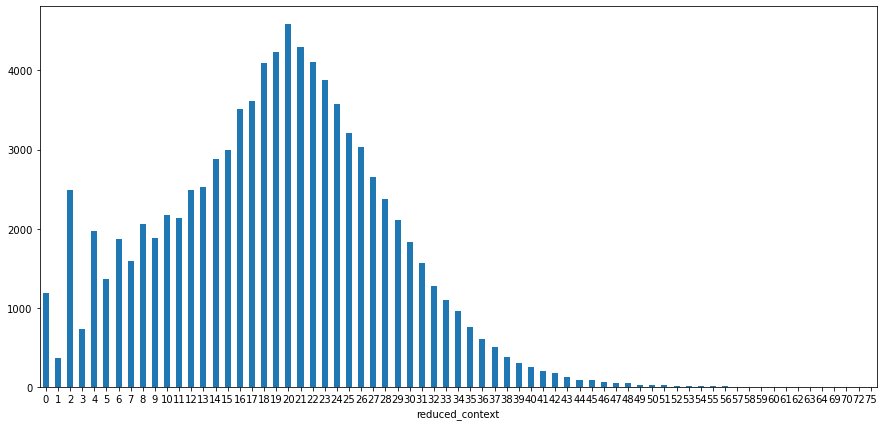

In [103]:
grouped = train_joint_df.groupby(train_joint_df['reduced_context'].map(lambda x: list(flatten(x)) ).str.len())
num_of_context_sentences = grouped.size()  # count of each  

# distribution of number of context sentences
plot = num_of_context_sentences.plot(kind = 'bar', figsize=(15, 7))
plt.xticks(rotation=0)                                    # show label text horizontally 
plt.show() 

#### answer

In [104]:
train_joint_df['normalized_answer_in_reduced_context'] = train_joint_df.apply(lambda row:  findWord(row['answer'], row['reduced_context_joint']) == True , axis = 1)

In [105]:
train_joint_df.normalized_answer_in_reduced_context.describe()

count     90447
unique        2
top        True
freq      63793
Name: normalized_answer_in_reduced_context, dtype: object

63793 questions' answer in the context, 90447-63793 = 26654 questions' answer are not in the reduced context

In [106]:
train_joint_df.loc[(train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no')].shape[0]

66935

In [107]:
train_joint_df.loc[(train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no') | (train_joint_df['answer'] == '')].shape[0]

66942

In [108]:
train_joint_df.loc[(train_joint_df['normalized_answer_in_reduced_context'] == False) & (train_joint_df['answer'] != 'yes') & (train_joint_df['answer'] != 'no') & (train_joint_df['answer'] != '')].shape[0]

23505

In [109]:
train_joint_df.loc[train_joint_df['answer'] == ''].shape[0]

7

#### supporting facts

In [110]:
# Distribution of number of supporting facts in reduced_context
train_joint_df['num_of_sp_in_reduced_context'] = train_joint_df['supporting_facts_reduced_context'].map(lambda x: len(x))
grouped = train_joint_df.groupby(['num_of_sp_in_reduced_context'])
num_of_sp_in_reduced_context_counts = grouped.size()  # count of each 
num_of_sp_in_reduced_context_counts

num_of_sp_in_reduced_context
0    10412
1    30195
2    40172
3     8274
4     1285
5       93
6       14
7        2
dtype: int64

In [111]:
# ratio of supporting facts remained in the reduced context 
train_joint_df['sp_in_reduced_context_ratio'] = train_joint_df.apply(lambda row: len(row['supporting_facts_reduced_context']) / len(row['supporting_facts'])  , axis=1)

#train_joint_df['sp_in_reduced_context'].map(lambda x: sum(x) / len(x)) 
train_joint_df['sp_in_reduced_context_ratio']

0        0.500000
1        1.000000
2        0.250000
3        0.000000
4        0.000000
           ...   
90442    0.500000
90443    0.666667
90444    0.000000
90445    0.500000
90446    1.000000
Name: sp_in_reduced_context_ratio, Length: 90447, dtype: float64

In [112]:
train_joint_df['sp_in_reduced_context_ratio'].describe()

count    90447.000000
mean         0.660098
std          0.337404
min          0.000000
25%          0.500000
50%          0.666667
75%          1.000000
max          1.000000
Name: sp_in_reduced_context_ratio, dtype: float64

In [180]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))].apply(lambda row: len(row['supporting_facts_reduced_context']) / len(row['supporting_facts'])  , axis=1).describe()

count    66872.000000
mean         0.780051
std          0.277019
min          0.000000
25%          0.500000
50%          1.000000
75%          1.000000
max          1.000000
dtype: float64

In [183]:
# for questions whose answer in reduced_context, the ratio of supporting facts remained in the reduced context
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))].apply(lambda row: len(row['supporting_facts_reduced_context']) / len(row['supporting_facts'])  , axis=1).head(10)

1     1.000000
2     0.250000
5     0.333333
6     0.500000
7     0.500000
8     1.000000
13    1.000000
14    1.000000
15    0.600000
18    0.500000
dtype: float64

In [184]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))].iloc[5]

_id                                                              5a7d0db955429909bec76924
question                                The Dutch-Belgian television series that "Hous...
answer                                                                               2006
level                                                                              medium
type                                                                               bridge
context                                 [[House of Anubis, [House of Anubis is a myste...
supporting_facts                             [[House of Anubis, 0], [Het Huis Anubis, 1]]
reduced_context                         [[House of Anubis, [House of Anubis is a myste...
supporting_facts_reduced_context             [[House of Anubis, 0], [Het Huis Anubis, 1]]
question_phrases                        [[dutchbelgian television series, 0.2327723121...
paras_phrases                           [[[['house', 0.3333333333333333], ['anubis', 0...
common_phr

In [114]:
# reduced_context contains the answer, even though does not contain any supporting fact
train_joint_df.loc[(train_joint_df.num_of_sp_in_reduced_context == 0) & (train_joint_df.normalized_answer_in_reduced_context == True)].shape[0]

1774

In [115]:
train_joint_df.loc[(train_joint_df.num_of_sp_in_reduced_context == 0) & (train_joint_df.normalized_answer_in_reduced_context == True)].head(3)

,_id,question,answer,level,type,context,supporting_facts,reduced_context,supporting_facts_reduced_context,question_phrases,paras_phrases,common_phrases,path_phrases,extended_phrases,kept_para_sent,reduced_context_joint,normalized_answer_in_reduced_context,num_of_sp_in_reduced_context,sp_in_reduced_context_ratio
27,5ae3918b5542994393b9e709,Were Pavel Urysohn and Leonid Levin known for ...,no,medium,comparison,"[[Leonid Ramzin, [Leonid Konstantinovich Ramzi...","[[Pavel Urysohn, 0], [Leonid Levin, 0]]","[[Kate Dillon Levin, [Kate Dillon Levin (born ...",[],"[[leonid levin, 0.23639070780118254], [same ty...","[[[['leonid ramzin', 0.4330127018922193], ['le...","[leonid levin, work, pavel urysohn]","[many mass medium outlet, leonid levin, work, ...","[many mass medium outlet, leonid levin, work, ...","[[0, 1], [2], [], [], [1]]",kate dillon levin kate dillon levin born march...,True,0,0.0
86,5ab9672655429970cfb8eabd,Which industry do Richard Hawley and Chicago's...,rock band,easy,comparison,"[[Late Night Final, [Late Night Final is the s...","[[Catherine (alternative rock band), 0], [Rich...","[[Late Night Final, [Late Night Final is the s...",[],"[[richard hawley, 0.26763402048270435], [chica...","[[[['late night', 0.35355339059327373]], [['mi...",[richard hawley],[richard hawley],"[richard hawley, chicagos catherine, industry]","[[0], [0], [0], [], [0], [0], [2], [1], [0]]",late night final late night final is second st...,True,0,0.0
225,5abaebab55429939ce03dd66,In between Memphis International Airport and S...,memphis international airport,medium,comparison,"[[Southwest Georgia Regional Airport, [Southwe...","[[Memphis International Airport, 0], [Southwes...","[[FedEx Express Flight 1406, [FedEx Express Fl...",[],"[[memphis international airport, 0.25978557794...","[[[['southwest georgia regional airport', 0.37...","[one, memphis international airport, tennessee...","[one, tennessee, georgia, airport, memphis int...","[one, tennessee, georgia, airport, memphis int...","[[0], [], [0], [2, 5], [2], [0, 1], [0], [2, 3]]",fedex express flight 1406 fedex express flight...,True,0,0.0


In [116]:
train_joint_df.loc[train_joint_df._id=='5ab9672655429970cfb8eabd'].supporting_facts.values.tolist()

[[['Catherine (alternative rock band)', 0], ['Richard Hawley', 0]]]

In [117]:
train_joint_df.loc[train_joint_df._id=='5ab9672655429970cfb8eabd'].reduced_context.values.tolist()

[[['Late Night Final',
   ['Late Night Final is the second studio album (and first full-length album after the mini-album "Richard Hawley" released six months earlier) from musician Richard Hawley, released in the UK in October 2001 by Setanta Records.']],
  ["Lady's Bridge (album)",
   ["Lady's Bridge is the fifth studio album from musician Richard Hawley, released on 20 August 2007 in the UK and on 9 October 2007 in the US."]],
  ["Standing at the Sky's Edge",
   ["Standing at the Sky's Edge is the seventh studio album from English musician Richard Hawley, released in the UK on 7 May 2012 and in the US on 28 August 2012."]],
  ['Richard Hawley', []],
  ["Truelove's Gutter",
   ["Truelove's Gutter is the sixth studio album from musician Richard Hawley, released on 21 September 2009 in the UK and on 22 September 2009 in the US."]],
  ['Lowedges',
   ['Lowedges is the third studio album from musician Richard Hawley.']],
  ['A Heavy Nite With...',
   [' It has been alleged that Jason Buc

In [118]:
train_joint_df['sp_text_reduced_context'] = train_joint_df.apply(lambda row: [_normalize_text(dict(row['reduced_context'])[sp_t][sp_idx]) for (sp_t, sp_idx) in row['supporting_facts_reduced_context'] if(sp_idx < len(dict(row['reduced_context'])[sp_t])) ], axis = 1)

train_joint_df['sp_text_reduced_context']  

0        [first for women is womans magazine published ...
1        [oberoi family is indian family that is famous...
2        [milhouse mussolini van houten is fictional ch...
3                                                       []
4                                                       []
                               ...                        
90442    [she is daughter of actor bert remsen and cast...
90443    [liberty tree mall is shopping mall in danvers...
90444                                                   []
90445    [mv wilhelm gustloff was german military trans...
90446    [vietnam national cricket team represents viet...
Name: sp_text_reduced_context, Length: 90447, dtype: object

In [119]:
train_joint_df['normalized_answer_in_reduced_sp_text'] = train_joint_df.apply(lambda row: any([ findWord(row['answer'], f) == True for f in row['sp_text_reduced_context']]), axis = 1)
train_joint_df['normalized_answer_in_reduced_sp_text']

0        False
1         True
2         True
3        False
4        False
         ...  
90442    False
90443     True
90444    False
90445     True
90446     True
Name: normalized_answer_in_reduced_sp_text, Length: 90447, dtype: bool

In [120]:
train_joint_df.normalized_answer_in_reduced_sp_text.describe()

count     90447
unique        2
top        True
freq      56471
Name: normalized_answer_in_reduced_sp_text, dtype: object

In [121]:
train_joint_df.loc[(train_joint_df['normalized_answer_in_reduced_sp_text'] == False) & (train_joint_df['answer'] != 'yes') & (train_joint_df['answer'] != 'no') & (train_joint_df['answer'] != '')].shape[0]

29511

In [122]:
# reduced_context contain the answer, but the sp in reduced context does not contain the answer
train_joint_df.loc[(train_joint_df.normalized_answer_in_reduced_context == True) & (train_joint_df.normalized_answer_in_reduced_sp_text == False) ].shape[0]

7322

#### Save 
To train longformer on context vs reduced_context, compare run time and performance  
just over the questions has answer in the reduced_context
Thus save file contains only the questions has answer in the reduced_context

In [123]:
train_joint_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90447 entries, 0 to 90446
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   _id                                   90447 non-null  object 
 1   question                              90447 non-null  object 
 2   answer                                90447 non-null  object 
 3   level                                 90447 non-null  object 
 4   type                                  90447 non-null  object 
 5   context                               90447 non-null  object 
 6   supporting_facts                      90447 non-null  object 
 7   reduced_context                       90447 non-null  object 
 8   supporting_facts_reduced_context      90447 non-null  object 
 9   question_phrases                      90447 non-null  object 
 10  paras_phrases                         90447 non-null  object 
 11  common_phrases 

In [124]:
hotpot_reduced_train_df = train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no')) , ['supporting_facts', 'context', 'answer', '_id', 'question']]
hotpot_reduced_train_df.shape[0]

66872

In [125]:
hotpot_reduced_train_df.head(3)

,supporting_facts,context,answer,_id,question
1,"[[Oberoi family, 0], [The Oberoi Group, 0]]","[[Ritz-Carlton Jakarta, [The Ritz-Carlton Jaka...",delhi,5a879ab05542996e4f30887e,The Oberoi family is part of a hotel company t...
2,"[[Allie Goertz, 0], [Allie Goertz, 1], [Allie ...","[[Lisa Simpson, [Lisa Marie Simpson is a ficti...",president richard nixon,5a8d7341554299441c6b9fe5,Musician and satirist Allie Goertz wrote a son...
5,"[[Jonathan Stark (tennis), 0], [Jonathan Stark...","[[Li Na, [Li Na (; ; born 26 February 1982) is...",jonathan stark,5a7e36045542991319bc9440,Which tennis player won more Grand Slam titles...


In [126]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['reduced_context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of reduced_context sentences, including tilte

count    66872.000000
mean        20.457456
std          8.548174
min          1.000000
25%         15.000000
50%         21.000000
75%         26.000000
max         75.000000
Name: reduced_context, dtype: float64

In [127]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['reduced_context_joint'].str.len().describe()  # statistic of number of words in reduced_context

count    66872.00000
mean      1853.78888
std        969.94518
min          5.00000
25%       1174.00000
50%       1744.00000
75%       2421.00000
max       8703.00000
Name: reduced_context_joint, dtype: float64

In [128]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

count    66872.000000
mean        50.471139
std         11.229584
min          4.000000
25%         43.000000
50%         50.000000
75%         56.000000
max        154.000000
Name: context, dtype: float64

In [129]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['context'].map(lambda x: " ".join(list(flatten(x))) ).str.len().describe() # statistic of number of words in the context

count    66872.000000
mean      5604.017451
std       1555.974212
min        197.000000
25%       4581.000000
50%       5496.000000
75%       6499.000000
max      17163.000000
Name: context, dtype: float64

In [130]:
#hotpot_reduced_train_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/context/hotpot_reduced_train.json", orient="records") 

In [131]:
# save file contains only the questions with reduced_context has answer in the reduced_context
hotpot_train_reduced_context_df = train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no')) , ['supporting_facts_reduced_context', 'reduced_context', 'answer', '_id', 'question']] 

hotpot_train_reduced_context_df.rename(columns={'supporting_facts_reduced_context': 'supporting_facts', "reduced_context": "context"}, inplace=True)
hotpot_train_reduced_context_df.shape[0]

66872

In [132]:
#hotpot_train_reduced_context_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/reduced_context/hotpot_reduced_train_reduced_context.json", orient="records") 

### Dev_reduced_context 

In [98]:
dev_reduced_context_coref_fuzzy_df = pd.read_json('/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/dev_subtasks_out/hotpot_dev_reduced_context_coref_fuzzy.json') 

In [99]:
dev_reduced_context_coref_fuzzy_df.head(3)

,_id,answer,question,supporting_facts,context,type,level,path,question_phrases,question_phrases_text,paras_phrases,common_phrases,question_only_phrase,path_phrases,extended_phrases,kept_para_sent
0,5a8b57f25542995d1e6f1371,yes,Were Scott Derrickson and Ed Wood of the same ...,"[[Scott Derrickson, 0]]","[[Ed Wood (film), [Ed Wood is a 1994 American ...",comparison,hard,"{'directed': False, 'multigraph': False, 'grap...","[[ed wood, 0.28417589243191105], [scott derric...","[ed wood, scott derrickson, same nationality, ...","[[[['ed wood film', 0.4], ['ed wood', 0.353553...","[wood, ed wood, derrickson, scott derrickson]","[nationality, same nationality]","[ed wood, derrickson, film, wood, scott derric...","[ed wood, derrickson, film, wood, scott derric...","[[0, 1], [0, 1, 2], [0, 1, 2, 3], [], [0, 1], ..."
1,5a8c7595554299585d9e36b6,Chief of Protocol,What government position was held by the woman...,"[[Shirley Temple, 0], [Kiss and Tell (1945 fil...","[[Meet Corliss Archer, [Meet Corliss Archer, a...",bridge,hard,"{'directed': False, 'multigraph': False, 'grap...","[[corliss archer, 0.21343307099261202], [film ...","[corliss archer, film kiss, archer, woman, kis...","[[[['meet corliss archer', 0.4], ['corliss arc...","[film kiss, kiss, woman, government position, ...",[],"[kiss, date, woman, american, position, govern...","[kiss, date, woman, american, position, govern...","[[0, 1, 2], [0], [0, 1], [0], [0], [0, 1, 2], ..."
2,5a85ea095542994775f606a8,Animorphs,"What science fantasy young adult series, told ...","[[The Hork-Bajir Chronicles, 0], [The Hork-Baj...","[[Andre Norton Award, [The Andre Norton Award ...",bridge,hard,"{'directed': False, 'multigraph': False, 'grap...","[[science fantasy young adult series, 0.192038...","[science fantasy young adult series, enslave w...","[[[['andre norton award', 0.4], ['andre norton...","[book, person, enslave world, series, specie, ...",[alien specie],"[book, person, enslave world, series, specie, ...","[book, person, enslave world, series, specie, ...","[[0], [1, 2, 3], [0, 1, 2, 3], [2], [0, 1, 3, ..."


In [100]:
dev_reduced_context_coref_fuzzy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405 entries, 0 to 7404
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   _id                    7405 non-null   object
 1   answer                 7405 non-null   object
 2   question               7405 non-null   object
 3   supporting_facts       7405 non-null   object
 4   context                7405 non-null   object
 5   type                   7405 non-null   object
 6   level                  7405 non-null   object
 7   path                   7405 non-null   object
 8   question_phrases       7405 non-null   object
 9   question_phrases_text  7405 non-null   object
 10  paras_phrases          7405 non-null   object
 11  common_phrases         7405 non-null   object
 12  question_only_phrase   7405 non-null   object
 13  path_phrases           7405 non-null   object
 14  extended_phrases       7405 non-null   object
 15  kept_para_sent       

#### Example

In [101]:
dev_coref_fuzzy_joint_df = dev_question_df.join(dev_reduced_context_coref_fuzzy_df, rsuffix='_reduced_context')
dev_coref_fuzzy_joint_df = dev_coref_fuzzy_joint_df.loc[:, ['_id', 'question', 'answer', 'level', 'type', 'context', 'supporting_facts', 'context_reduced_context', 'supporting_facts_reduced_context', 'question_phrases_text', 'paras_phrases', 'common_phrases', 'path_phrases', 'path', 'question_only_phrase', 'extended_phrases', 'kept_para_sent']]
dev_coref_fuzzy_joint_df.rename(columns={'context_reduced_context': "reduced_context", "question_phrases_text": "question_phrases", "path_phrases":"Steiner_tree_phrase", 'path':"Steiner_tree"}, inplace=True)

In [102]:
dev_coref_fuzzy_joint_df.iloc[1]

_id                                                          5a8c7595554299585d9e36b6
question                            What government position was held by the woman...
answer                                                              chief of protocol
level                                                                            hard
type                                                                           bridge
context                             [[Meet Corliss Archer, [Meet Corliss Archer, a...
supporting_facts                    [[Kiss and Tell (1945 film), 0], [Shirley Temp...
reduced_context                     [[Meet Corliss Archer, [Meet Corliss Archer, a...
supporting_facts_reduced_context    [[Shirley Temple, 0], [Kiss and Tell (1945 fil...
question_phrases                    [corliss archer, film kiss, archer, woman, kis...
paras_phrases                       [[[['meet corliss archer', 0.4], ['corliss arc...
common_phrases                      [film kiss, kiss, 

In [103]:
dev_coref_fuzzy_joint_df.iloc[1].question

'What government position was held by the woman who portrayed Corliss Archer in the film Kiss and Tell?'

In [104]:
question_phrases = dev_coref_fuzzy_joint_df.iloc[1].question_phrases
question_phrases

['corliss archer',
 'film kiss',
 'archer',
 'woman',
 'kiss',
 'position',
 'government position']

The pharse extraction is not perfect, *'film'* and *'Kiss and Tell'* will be better.

In [105]:
dev_coref_fuzzy_joint_df.iloc[1].paras_phrases

[[[['meet corliss archer', 0.4],
   ['corliss archer', 0.353553390593273],
   ['meet', 0.272165526975908],
   ['archer', 0.272165526975908]],
  [['radio golden age', 0.18985858955553803],
   ['corliss archer program', 0.18684782617842502],
   ['corliss archer', 0.156214244124983],
   ['january 7 1943 september 30 1956', 0.15579934502414403],
   ['program', 0.139882443815941],
   ['september', 0.133571845512063],
   ['january', 0.126783158564227],
   ['age', 0.124783579977305]],
  [['meet corliss archer program', 0.213146569131158],
   ['judy corliss archer program', 0.21256246947044502],
   ['corliss archer program', 0.211817087644067],
   ['judy corliss archer', 0.18649654198430501],
   ['corliss archer', 0.179833416542128],
   ['program', 0.154872839309791],
   ['popular date', 0.121532348603197],
   ['cbss answer', 0.12054691513939401],
   ['summer replacement', 0.119249712326305],
   ['replacement', 0.096367228923616],
   ['answer', 0.09353450869926101],
   ['date', 0.0928691309559

In [106]:
dev_coref_fuzzy_joint_df.iloc[1].common_phrases

['film kiss',
 'kiss',
 'woman',
 'government position',
 'corliss archer',
 'archer',
 'position']

In [107]:
dev_coref_fuzzy_joint_df.iloc[1].question_only_phrase

[]

In [108]:
dev_coref_fuzzy_joint_df.iloc[1].Steiner_tree_phrase

['kiss',
 'date',
 'woman',
 'american',
 'position',
 'government position',
 'corliss archer',
 'archer',
 'film kiss']

In [109]:
dev_coref_fuzzy_joint_df.iloc[1].Steiner_tree

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'score': 0.29121767187564, 'id': 'film kiss'},
  {'score': 0.169502402313631, 'id': 'kiss'},
  {'score': 0.09584199498788501, 'id': 'woman'},
  {'score': 0.14043643876659, 'id': 'american'},
  {'score': 0.158675933716342, 'id': 'government position'},
  {'score': 0.10320094199823301, 'id': 'date'},
  {'score': 0.16597964987587002, 'id': 'corliss archer'},
  {'score': 0.10609354033964401, 'id': 'archer'},
  {'score': 0.19744951406626302, 'id': 'position'}],
 'links': [{'src': [[5, 1]],
   'source': 'film kiss',
   'target': 'corliss archer'},
  {'src': [[6, 1]], 'source': 'film kiss', 'target': 'archer'},
  {'src': [[5, 3]], 'source': 'film kiss', 'target': 'american'},
  {'src': [[5, 3]], 'source': 'film kiss', 'target': 'kiss'},
  {'src': [[5, 3]], 'source': 'film kiss', 'target': 'film kiss'},
  {'src': [[5, 1], [5, 3]], 'source': 'kiss', 'target': 'american'},
  {'src': [[5, 1]], 'source': 'kiss', 'target': 'corliss

nodes to draw ['film kiss', 'kiss', 'woman', 'american', 'government position', 'date', 'corliss archer', 'archer', 'position']


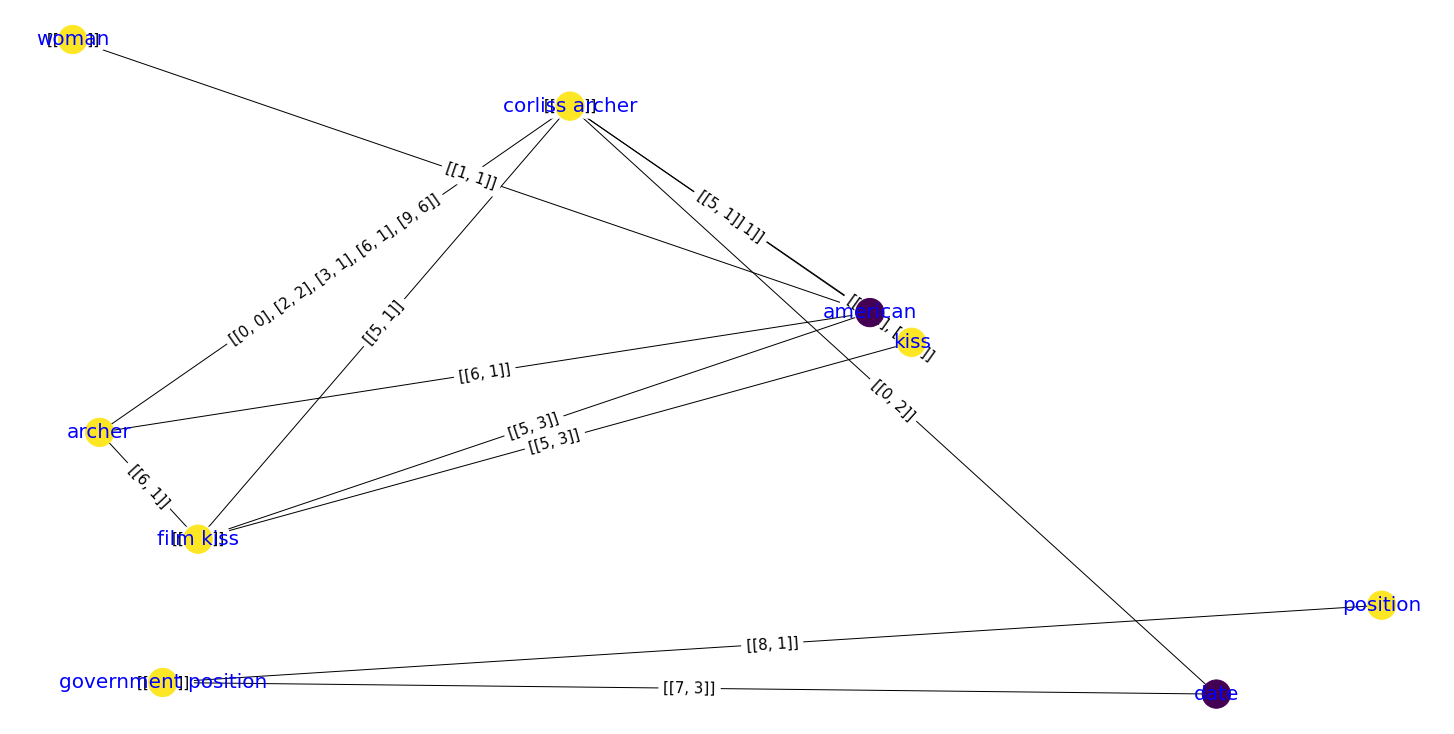

(film kiss, corliss archer, {'src': [[5, 1]]})
(film kiss, archer, {'src': [[6, 1]]})
(film kiss, american, {'src': [[5, 3]]})
(film kiss, kiss, {'src': [[5, 3]]})
(film kiss, film kiss, {'src': [[5, 3]]})
(kiss, film kiss, {'src': [[5, 3]]})
(kiss, american, {'src': [[5, 1], [5, 3]]})
(kiss, corliss archer, {'src': [[5, 1]]})
(woman, american, {'src': [[1, 1]]})
(woman, woman, {'src': [[1, 1]]})
(american, film kiss, {'src': [[5, 3]]})
(american, kiss, {'src': [[5, 1], [5, 3]]})
(american, woman, {'src': [[1, 1]]})
(american, corliss archer, {'src': [[5, 1]]})
(american, archer, {'src': [[6, 1]]})
(government position, date, {'src': [[7, 3]]})
(government position, government position, {'src': [[4, 1]]})
(government position, position, {'src': [[8, 1]]})
(date, government position, {'src': [[7, 3]]})
(date, corliss archer, {'src': [[0, 2]]})
(corliss archer, film kiss, {'src': [[5, 1]]})
(corliss archer, kiss, {'src': [[5, 1]]})
(corliss archer, american, {'src': [[5, 1]]})
(corliss a

In [110]:
Steiner_tree = json_graph.node_link_graph(dev_coref_fuzzy_joint_df.iloc[1].Steiner_tree)
vis_graph(Steiner_tree, Steiner_tree.nodes(), question_phrases)

In [111]:
dev_coref_fuzzy_joint_df.iloc[1].extended_phrases

['kiss',
 'date',
 'woman',
 'american',
 'position',
 'government position',
 'corliss archer',
 'archer',
 'film kiss']

In [112]:
dev_coref_fuzzy_joint_df.iloc[1].supporting_facts

[['Kiss and Tell (1945 film)', 0],
 ['Shirley Temple', 0],
 ['Shirley Temple', 1]]

In [113]:
dev_coref_fuzzy_joint_df.iloc[1].supporting_facts_reduced_context

[['Shirley Temple', 0], ['Kiss and Tell (1945 film)', 0]]

In [114]:
list(enumerate(dev_coref_fuzzy_joint_df.iloc[1].context))

[(0,
  ['Meet Corliss Archer',
   ["Meet Corliss Archer, a program from radio's Golden Age, ran from January 7, 1943 to September 30, 1956.",
    ' Although it was CBS\'s answer to NBC\'s popular "A Date with Judy", it was also broadcast by NBC in 1948 as a summer replacement for "The Bob Hope Show".',
    ' From October 3, 1952 to June 26, 1953, it aired on ABC, finally returning to CBS.',
    " Despite the program's long run, fewer than 24 episodes are known to exist."]]),
 (1,
  ['Shirley Temple',
   ["Shirley Temple Black (April 23, 1928 – February 10, 2014) was an American actress, singer, dancer, businesswoman, and diplomat who was Hollywood's number one box-office draw as a child actress from 1935 to 1938.",
    ' As an adult, she was named United States ambassador to Ghana and to Czechoslovakia and also served as Chief of Protocol of the United States.']]),
 (2,
  ['Janet Waldo',
   ['Janet Marie Waldo (February 4, 1920 – June 12, 2016) was an American radio and voice actress.'

In [115]:
list(enumerate(dev_coref_fuzzy_joint_df.iloc[1].paras_phrases[3]))

[(0,
  [['meet corliss archer tv series', 0.34992710611188205],
   ['corliss archer tv series', 0.33948988986890904],
   ['meet', 0.194465435759403],
   ['series', 0.194465435759403]]),
 (1,
  [['cbs july 13 1951', 0.18857144997327002],
   ['american television sitcom', 0.159188666365691],
   ['meet corliss archer', 0.15095557597925902],
   ['american television', 0.14685800309084301],
   ['corliss archer', 0.142408970988765],
   ['cbs july', 0.13959341072444],
   ['ziv company', 0.13603577180252402],
   ['april', 0.124098743924286],
   ['archer', 0.11587773096836401],
   ['july', 0.11234697239334801],
   ['company', 0.10472038595947401],
   ['syndication', 0.09997720082818501],
   ['april december 1954', 0.098156403539514],
   ['sitcom', 0.098156327115307],
   ['december', 0.093503675436457]]),
 (2,
  [['radio series', 0.21698105332661702],
   ['series', 0.19481058068308402],
   ['f hugh herbert', 0.194489742840908],
   ['short story', 0.18073009012272],
   ['same name', 0.17185411418

Even though 'Kiss and Tell (1945 film)' is found based on *'corliss archer'*, and even find the sentence that contains *'shirley temple'*, but it failed to identify *'shirley temple'* as an extended phrase to further explore other sentences that contains *'shirley temple'*. This is mainly because *'Kiss and Tell'* is not recognized in question, and thus *'shirley temple'* is not included in the path when there is only one common phrase.

#### reduced Context 

In [116]:
dev_coref_fuzzy_joint_df['reduced_context_joint'] = dev_coref_fuzzy_joint_df['reduced_context'].map(lambda x: " ".join(list(flatten(x)) ))
dev_coref_fuzzy_joint_df['reduced_context_joint'] = dev_coref_fuzzy_joint_df['reduced_context_joint'].map(_normalize_text)  

In [117]:
dev_coref_fuzzy_joint_df['reduced_context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

count    7405.000000
mean       30.175152
std        10.055571
min         0.000000
25%        24.000000
50%        30.000000
75%        36.000000
max        80.000000
Name: reduced_context, dtype: float64

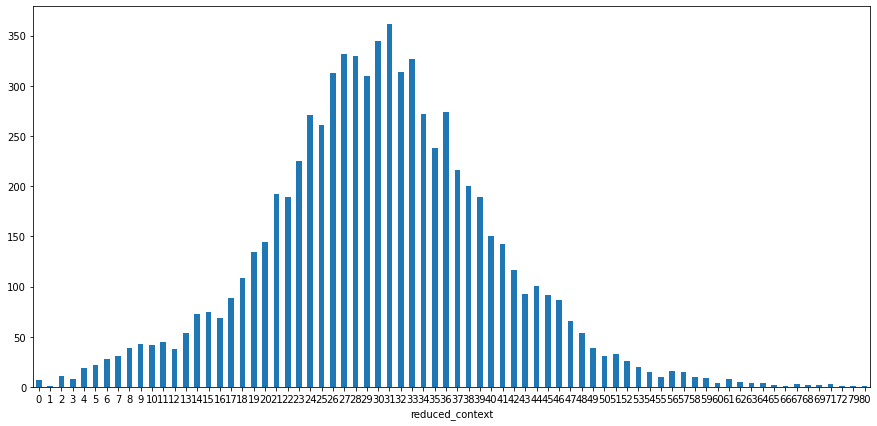

In [118]:
grouped = dev_coref_fuzzy_joint_df.groupby(dev_coref_fuzzy_joint_df['reduced_context'].map(lambda x: list(flatten(x)) ).str.len())
num_of_context_sentences = grouped.size()  # count of each  

# distribution of number of context sentences
plot = num_of_context_sentences.plot(kind = 'bar', figsize=(15, 7))
plt.xticks(rotation=0)                                    # show label text horizontally 
plt.show() 

#### answer

In [119]:
dev_coref_fuzzy_joint_df['normalized_answer_in_reduced_context'] = dev_coref_fuzzy_joint_df.apply(lambda row:  findWord(row['answer'], row['reduced_context_joint']) == True , axis = 1)

In [120]:
dev_coref_fuzzy_joint_df.normalized_answer_in_reduced_context.value_counts()

True     6209
False    1196
Name: normalized_answer_in_reduced_context, dtype: int64

In [121]:
# dev_coref_fuzzy_joint_df.loc[(dev_coref_fuzzy_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_coref_fuzzy_joint_df['answer'] == 'yes') | (dev_coref_fuzzy_joint_df['answer'] == 'no') | (dev_coref_fuzzy_joint_df['answer'] == '')].shape[0]

In [122]:
# dev_coref_fuzzy_joint_df.loc[(dev_coref_fuzzy_joint_df.reduced_context.str.len() > 0) & ((dev_coref_fuzzy_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_coref_fuzzy_joint_df['answer'] == 'yes') | (dev_coref_fuzzy_joint_df['answer'] == 'no')) ].shape[0]

##### Outliers

In [123]:
dev_coref_fuzzy_outliers = dev_coref_fuzzy_joint_df.loc[(dev_coref_fuzzy_joint_df['normalized_answer_in_reduced_context'] == False) & (dev_coref_fuzzy_joint_df['answer'] != 'yes') & (dev_coref_fuzzy_joint_df['answer'] != 'no') & (dev_coref_fuzzy_joint_df['answer'] != '')]
dev_coref_fuzzy_outliers.shape[0]

975

###### Outlier 1

In [124]:
print(dev_coref_fuzzy_outliers.iloc[1]._id)
dev_coref_fuzzy_outliers.iloc[1].question

5ae6050f55429929b0807a5e


'This singer of A Rather Blustery Day also voiced what hedgehog?'

In [125]:
question_phrases = dev_coref_fuzzy_outliers.iloc[1].question_phrases
question_phrases

['rather blustery day', 'blustery day', 'day', 'singer']

The pharse extraction is not perfect, *'hedgehog'* should be extract

In [126]:
dev_coref_fuzzy_outliers.iloc[1].paras_phrases

[[[['hip hip poohray', 0.5044482440783511], ['poohray', 0.301689614795359]],
  [['hip hip poohray', 0.5044482440783511], ['poohray', 0.301689614795359]],
  [['musical film featurette winnie pooh', 0.286242605046026],
   ['winnie pooh', 0.22551544637198],
   ['pooh', 0.174988056088504],
   ['blustery day', 0.17132573945777402],
   ['1968', 0.157165052369262],
   ['day', 0.120924863406781],
   ['song', 0.11847644620023101]],
  [['dramatic tension', 0.272634127576733],
   ['release', 0.21455004183821702],
   ['tension', 0.209873849262274],
   ['cast', 0.19107370450372602],
   ['story', 0.174686784560758]],
  [['1977 musical film', 0.165363602695574],
   ['three winniethepooh featurette', 0.16350523158371202],
   ['many adventure', 0.150688347409628],
   ['promotional tagline', 0.134101776804533],
   ['blustery day', 0.127114644868006],
   ['winnie pooh', 0.12221584729512001],
   ['1977', 0.11714358985861902],
   ['adventure', 0.11636319672675001],
   ['winniethepooh', 0.11482939525395601]

In [127]:
dev_coref_fuzzy_outliers.iloc[1].common_phrases

['day', 'rather blustery day', 'blustery day', 'singer']

In [128]:
dev_coref_fuzzy_outliers.iloc[1].Steiner_tree_phrase

['day', 'rather blustery day', 'blustery day', 'singer']

In [129]:
dev_coref_fuzzy_outliers.iloc[1].Steiner_tree

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'score': 0.066339704272005, 'id': 'day'},
  {'score': 0.4, 'id': 'rather blustery day'},
  {'score': 0.179145110995776, 'id': 'blustery day'},
  {'score': 0.15372599434953602, 'id': 'singer'}],
 'links': [{'src': [[4, 2]], 'source': 'day', 'target': 'blustery day'},
  {'src': [[4, 2]], 'source': 'day', 'target': 'day'},
  {'src': [[4, 2]], 'source': 'day', 'target': 'singer'},
  {'src': [[8, 0]], 'source': 'day', 'target': 'rather blustery day'},
  {'src': [[4, 2]], 'source': 'blustery day', 'target': 'singer'},
  {'src': [[3, 1]], 'source': 'singer', 'target': 'singer'}]}

nodes to draw ['day', 'rather blustery day', 'blustery day', 'singer']


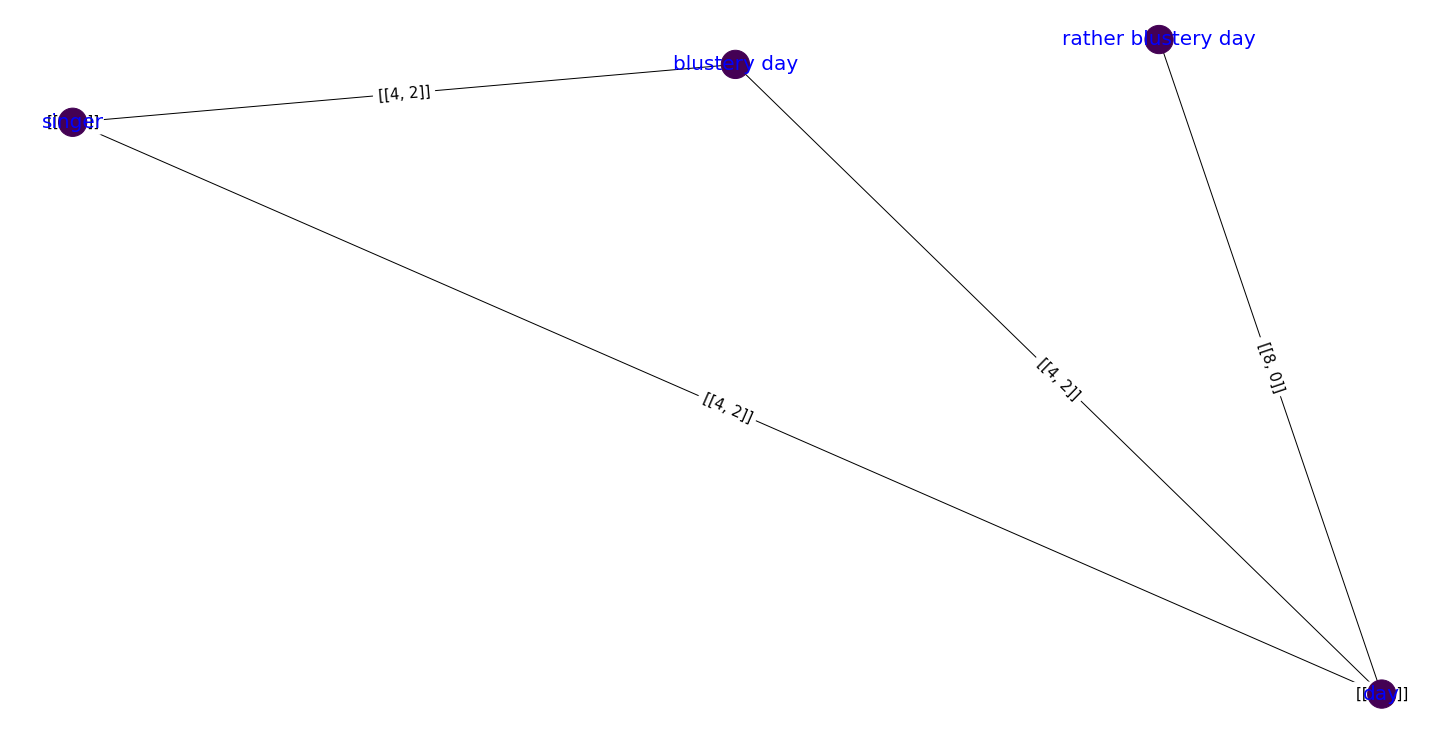

(day, blustery day, {'src': [[4, 2]]})
(day, day, {'src': [[4, 2]]})
(day, singer, {'src': [[4, 2]]})
(day, rather blustery day, {'src': [[8, 0]]})
(rather blustery day, day, {'src': [[8, 0]]})
(blustery day, day, {'src': [[4, 2]]})
(blustery day, singer, {'src': [[4, 2]]})
(singer, day, {'src': [[4, 2]]})
(singer, blustery day, {'src': [[4, 2]]})
(singer, singer, {'src': [[3, 1]]})


In [130]:
Steiner_tree = json_graph.node_link_graph(dev_coref_fuzzy_outliers.iloc[1].Steiner_tree)
vis_graph(Steiner_tree, Steiner_tree.nodes(), question_phrases)

###### Outlier 2

In [131]:
print(dev_coref_fuzzy_outliers.iloc[2]._id)
dev_coref_fuzzy_outliers.iloc[2].question

5adddccd5542997dc7907069


'Aside from the Apple Remote, what other device can control the program Apple Remote was originally designed to interact with?'

In [132]:
question_phrases = dev_coref_fuzzy_outliers.iloc[2].question_phrases
question_phrases

['program apple remote', 'other device', 'remote', 'device']

In [133]:
dev_coref_fuzzy_outliers.iloc[2].Steiner_tree_phrase

['other device', 'program apple remote', 'remote', 'device']

In [134]:
dev_coref_fuzzy_outliers.iloc[2].common_phrases

['other device', 'program apple remote', 'remote', 'device']

In [135]:
dev_coref_fuzzy_outliers.iloc[2].question_only_phrase

[]

In [136]:
dev_coref_fuzzy_outliers.iloc[2].Steiner_tree

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'score': 0.134080593677847, 'id': 'other device'},
  {'score': 0.177537434556711, 'id': 'device'},
  {'score': 0.135457461889153, 'id': 'remote'},
  {'score': 0.148885372493224, 'id': 'program apple remote'}],
 'links': [{'src': [[4, 1], [4, 4]],
   'source': 'other device',
   'target': 'remote'},
  {'src': [[4, 1], [4, 4]], 'source': 'other device', 'target': 'device'},
  {'src': [[4, 1], [4, 4]], 'source': 'device', 'target': 'remote'},
  {'src': [[6, 6]], 'source': 'device', 'target': 'device'},
  {'src': [[6, 5]], 'source': 'device', 'target': 'program apple remote'},
  {'src': [[8, 9]], 'source': 'remote', 'target': 'remote'},
  {'src': [[2, 5]], 'source': 'remote', 'target': 'program apple remote'},
  {'src': [[2, 5]],
   'source': 'program apple remote',
   'target': 'program apple remote'}]}

nodes to draw ['other device', 'device', 'remote', 'program apple remote']


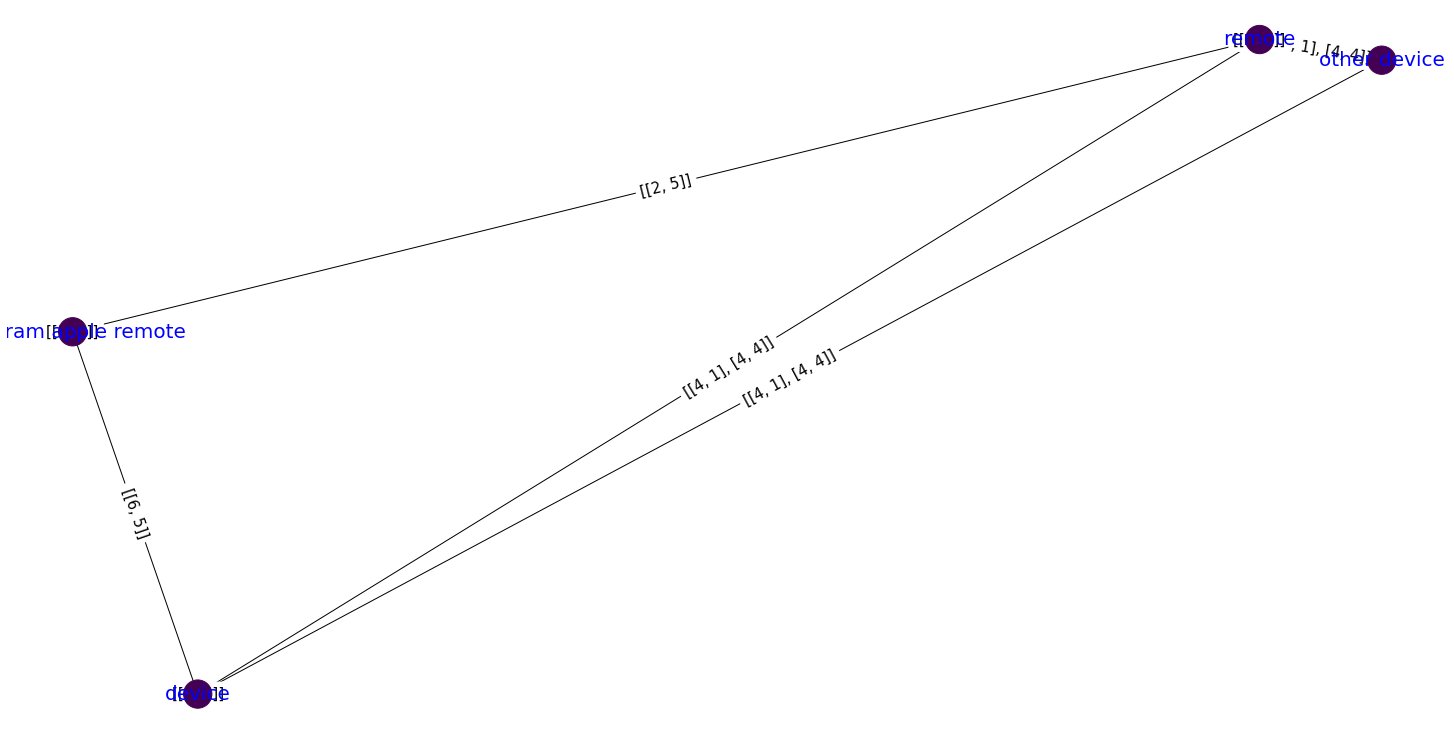

(other device, remote, {'src': [[4, 1], [4, 4]]})
(other device, device, {'src': [[4, 1], [4, 4]]})
(device, other device, {'src': [[4, 1], [4, 4]]})
(device, remote, {'src': [[4, 1], [4, 4]]})
(device, device, {'src': [[6, 6]]})
(device, program apple remote, {'src': [[6, 5]]})
(remote, other device, {'src': [[4, 1], [4, 4]]})
(remote, device, {'src': [[4, 1], [4, 4]]})
(remote, remote, {'src': [[8, 9]]})
(remote, program apple remote, {'src': [[2, 5]]})
(program apple remote, device, {'src': [[6, 5]]})
(program apple remote, remote, {'src': [[2, 5]]})
(program apple remote, program apple remote, {'src': [[2, 5]]})


In [137]:
Steiner_tree = json_graph.node_link_graph(dev_coref_fuzzy_outliers.iloc[2].Steiner_tree)
vis_graph(Steiner_tree, Steiner_tree.nodes(), question_phrases)

In [138]:
dev_coref_fuzzy_outliers.iloc[2].supporting_facts_reduced_context

[['Apple Remote', 0], ['Apple Remote', 1]]

In [139]:
dev_coref_fuzzy_outliers.iloc[2].supporting_facts

[['Apple Remote', 0],
 ['Apple Remote', 1],
 ['Front Row (software)', 0],
 ['Front Row (software)', 1]]

###### Outlier 3

In [161]:
print(dev_coref_fuzzy_outliers.iloc[3]._id)
dev_coref_fuzzy_outliers.iloc[3].question

5a722b8655429971e9dc9329


"Who was the writer of These Boots Are Made for Walkin' and who died in 2007?"

In [162]:
question_phrases = dev_coref_fuzzy_outliers.iloc[3].question_phrases
question_phrases

['boot', 'walkin', 'writer', '2007']

The pharse extraction is not perfect, *'These Boots Are Made for Walkin'* should be extract

In [140]:
dev_coref_fuzzy_outliers.iloc[3].paras_phrasesThese Boots Are Made for Walkin

[[[['nancy sinatra', 0.433012701892219], ['sinatra', 0.33333333333333304]],
  [['june 8 1940', 0.23439850039186003],
   ['nancy sandra sinatra', 0.21069332852744202],
   ['american singer', 0.186783655488923],
   ['sinatra', 0.15804261301977202],
   ['american', 0.151608817513354],
   ['singer', 0.135512604423901],
   ['actress', 0.11584849850914102]],
  [['nancy sandra sinatra', 0.22195534558603602],
   ['nancy barbato sinatra', 0.198482854256871],
   ['nancy sandra sinatra nancy barbato sinatra', 0.180459182565839],
   ['june 8 1940', 0.17717881195082502],
   ['1940 1966 signature', 0.163123368564589],
   ['sinatra', 0.157954195831837],
   ['june 8', 0.15087977093020402],
   ['eld daughter', 0.11547901112915801],
   ['signature', 0.108318138508581],
   ['boot', 0.10600377495621201],
   ['daughter', 0.088621949791494],
   ['walkin', 0.07905801226820501]]],
 [[['kon kan', 0.433012701892219], ['kan', 0.33333333333333304]],
  [['canadian synthpop project', 0.218792923227125],
   ['barry 

In [144]:
dev_coref_fuzzy_outliers.iloc[3].Steiner_tree_phrase

['2007', 'walkin', 'writer', 'boot']

In [145]:
dev_coref_fuzzy_outliers.iloc[3].common_phrases

['2007', 'writer', 'walkin', 'boot']

In [146]:
dev_coref_fuzzy_outliers.iloc[3].question_only_phrase

[]

In [147]:
dev_coref_fuzzy_outliers.iloc[3].Steiner_tree

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'score': 0.12007279509681501, 'id': '2007'},
  {'score': 0.08208125030372501, 'id': 'writer'},
  {'score': 0.170992270085209, 'id': 'walkin'},
  {'score': 0.227500234122084, 'id': 'boot'}],
 'links': [{'src': [[4, 2]], 'source': '2007', 'target': 'boot'},
  {'src': [[4, 2]], 'source': '2007', 'target': 'walkin'},
  {'src': [[9, 1]], 'source': '2007', 'target': 'writer'},
  {'src': [[2, 5]], 'source': 'writer', 'target': 'walkin'},
  {'src': [[9, 1]], 'source': 'writer', 'target': 'writer'},
  {'src': [[2, 7]], 'source': 'walkin', 'target': 'boot'},
  {'src': [[8, 1]], 'source': 'boot', 'target': 'boot'}]}

nodes to draw ['2007', 'writer', 'walkin', 'boot']


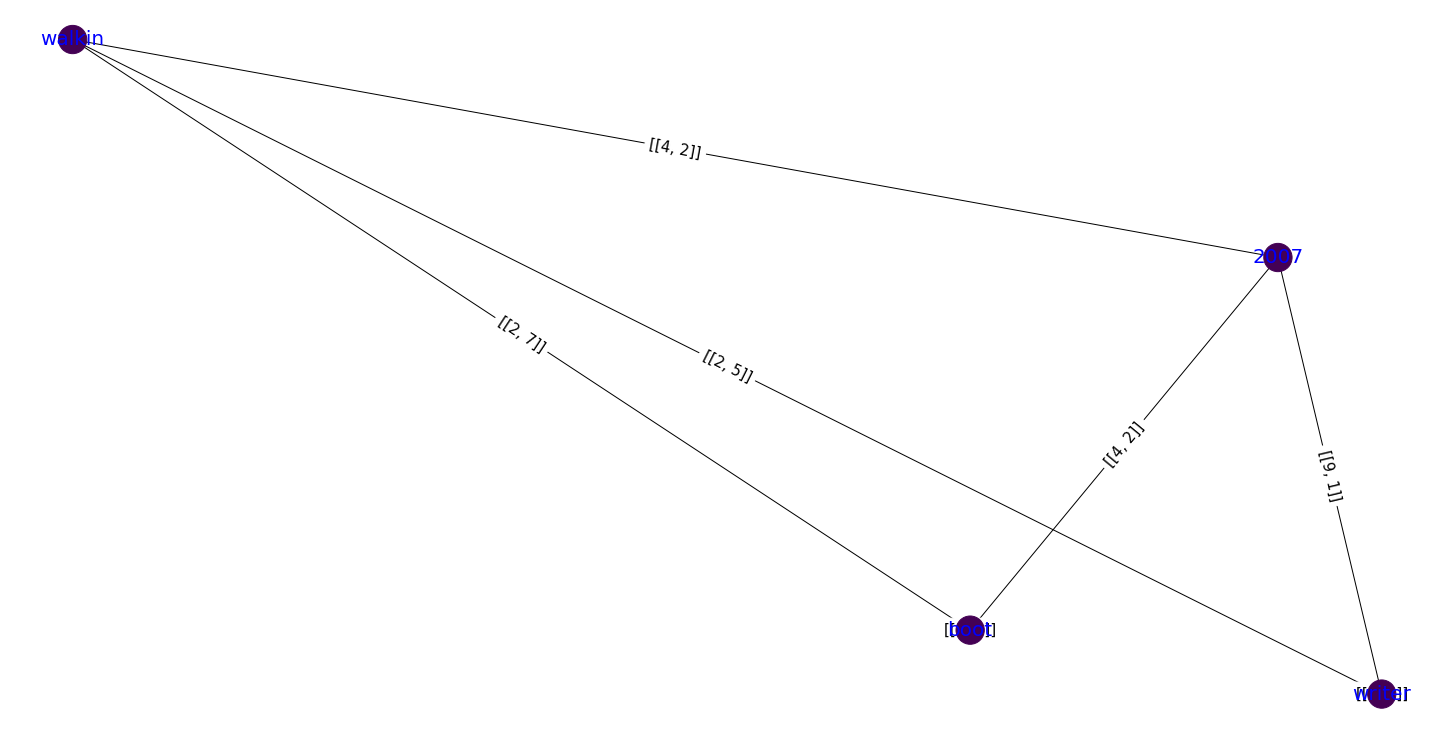

(2007, boot, {'src': [[4, 2]]})
(2007, walkin, {'src': [[4, 2]]})
(2007, writer, {'src': [[9, 1]]})
(writer, 2007, {'src': [[9, 1]]})
(writer, walkin, {'src': [[2, 5]]})
(writer, writer, {'src': [[9, 1]]})
(walkin, 2007, {'src': [[4, 2]]})
(walkin, writer, {'src': [[2, 5]]})
(walkin, boot, {'src': [[2, 7]]})
(boot, 2007, {'src': [[4, 2]]})
(boot, walkin, {'src': [[2, 7]]})
(boot, boot, {'src': [[8, 1]]})


In [148]:
Steiner_tree = json_graph.node_link_graph(dev_coref_fuzzy_outliers.iloc[3].Steiner_tree)
vis_graph(Steiner_tree, Steiner_tree.nodes(), question_phrases)

In [149]:
dev_coref_fuzzy_outliers.iloc[3].supporting_facts_reduced_context

[["These Boots Are Made for Walkin'", 0]]

In [150]:
dev_coref_fuzzy_outliers.iloc[3].supporting_facts

[["These Boots Are Made for Walkin'", 0], ['Lee Hazlewood', 0]]

#### supporting facts

In [185]:
# Distribution of number of supporting facts in reduced_context
dev_coref_fuzzy_joint_df['num_of_sp_in_reduced_context'] = dev_coref_fuzzy_joint_df['supporting_facts_reduced_context'].map(lambda x: len(x))
grouped = dev_coref_fuzzy_joint_df.groupby(['num_of_sp_in_reduced_context'])
num_of_sp_in_reduced_context_counts = grouped.size()  # count of each 
num_of_sp_in_reduced_context_counts

num_of_sp_in_reduced_context
0     183
1    1353
2    4309
3    1247
4     276
5      29
6       5
7       3
dtype: int64

In [178]:
dev_coref_fuzzy_joint_df['sp_in_reduced_context_ratio'].describe()

count    7405.000000
mean        0.839550
std         0.253106
min         0.000000
25%         0.666667
50%         1.000000
75%         1.000000
max         1.000000
Name: sp_in_reduced_context_ratio, dtype: float64

In [179]:
# for questions whose answer in reduced_context, the ratio of supporting facts remained in the reduced context
dev_coref_fuzzy_joint_df.loc[(dev_coref_fuzzy_joint_df.reduced_context.str.len() > 0) & ((dev_coref_fuzzy_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_coref_fuzzy_joint_df['answer'] == 'yes') | (dev_coref_fuzzy_joint_df['answer'] == 'no'))].apply(lambda row: len(row['supporting_facts_reduced_context']) / len(row['supporting_facts'])  , axis=1).head(10)

0     0.5
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     0.0
10    1.0
dtype: float64

In [177]:
# ratio of supporting facts remained in the reduced context 
dev_coref_fuzzy_joint_df['sp_in_reduced_context_ratio'] = dev_coref_fuzzy_joint_df.apply(lambda row: len(row['supporting_facts_reduced_context']) / len(row['supporting_facts'])  , axis=1)

#dev_joint_df['sp_in_reduced_context'].map(lambda x: sum(x) / len(x)) 
dev_coref_fuzzy_joint_df['sp_in_reduced_context_ratio']

0       0.500000
1       0.666667
2       1.000000
3       1.000000
4       1.000000
          ...   
7400    0.666667
7401    0.500000
7402    1.000000
7403    1.000000
7404    1.000000
Name: sp_in_reduced_context_ratio, Length: 7405, dtype: float64

In [186]:
# reduced_context contains the answer, even though does not contain any supporting fact
dev_coref_fuzzy_joint_df.loc[(dev_coref_fuzzy_joint_df.num_of_sp_in_reduced_context == 0) & (dev_coref_fuzzy_joint_df.normalized_answer_in_reduced_context == True)].shape[0]

36

In [187]:
# map sp from id to text
dev_coref_fuzzy_joint_df['sp_text_reduced_context'] = dev_coref_fuzzy_joint_df.apply(lambda row: [_normalize_text(dict(row['reduced_context'])[sp_t][sp_idx]) for (sp_t, sp_idx) in row['supporting_facts_reduced_context'] if(sp_idx < len(dict(row['reduced_context'])[sp_t])) ], axis = 1)

dev_coref_fuzzy_joint_df['sp_text_reduced_context']  

0       [scott derrickson born july 16 1966 is america...
1       [shirley temple black april 23 1928 – february...
2       [horkbajir chronicles is second companion book...
3       [laleli mosque turkish laleli camii or tulip m...
4       [adriana trigiani is italian american bestsell...
                              ...                        
7400    [coke kahani urdu کوک کہانی‎ is 2012 pakistani...
7401    [canfields diet chocolate fudge soda is zeroca...
7402    [billy is large scenthound originating from ce...
7403    [dig is american alternative rock band from lo...
7404    [analog devices inc also known as adi or analo...
Name: sp_text_reduced_context, Length: 7405, dtype: object

In [188]:
dev_coref_fuzzy_joint_df['normalized_answer_in_reduced_sp_text'] = dev_coref_fuzzy_joint_df.apply(lambda row: any([ findWord(row['answer'], f) == True for f in row['sp_text_reduced_context']]), axis = 1)
dev_coref_fuzzy_joint_df['normalized_answer_in_reduced_sp_text']

0       False
1       False
2        True
3       False
4        True
        ...  
7400     True
7401     True
7402    False
7403    False
7404     True
Name: normalized_answer_in_reduced_sp_text, Length: 7405, dtype: bool

In [192]:
dev_coref_fuzzy_joint_df.loc[(dev_coref_fuzzy_joint_df['answer'] != 'yes') & (dev_coref_fuzzy_joint_df['answer'] != 'no') & (dev_coref_fuzzy_joint_df['answer'] != '')].normalized_answer_in_reduced_sp_text.value_counts()

True     5697
False    1248
Name: normalized_answer_in_reduced_sp_text, dtype: int64

In [193]:
# reduced_context contain the answer, but the sp in reduced context does not contain the answer
dev_coref_fuzzy_joint_df.loc[(dev_coref_fuzzy_joint_df.normalized_answer_in_reduced_context == True) & (dev_coref_fuzzy_joint_df.normalized_answer_in_reduced_sp_text == False) ].shape[0]

401

#### Reduced Question 
To train longformer on context vs reduced_context, compare run time and performance  
just over the questions has answer in the reduced_context
Thus save file contains only the questions has answer in the reduced_context

In [194]:
dev_coref_fuzzy_joint_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405 entries, 0 to 7404
Data columns (total 23 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   _id                                   7405 non-null   object 
 1   question                              7405 non-null   object 
 2   answer                                7405 non-null   object 
 3   level                                 7405 non-null   object 
 4   type                                  7405 non-null   object 
 5   context                               7405 non-null   object 
 6   supporting_facts                      7405 non-null   object 
 7   reduced_context                       7405 non-null   object 
 8   supporting_facts_reduced_context      7405 non-null   object 
 9   question_phrases                      7405 non-null   object 
 10  paras_phrases                         7405 non-null   object 
 11  common_phrases   

In [195]:
hotpot_reduced_dev_coref_fuzzy_df = dev_coref_fuzzy_joint_df.loc[(dev_coref_fuzzy_joint_df.reduced_context.str.len() > 0) & ((dev_coref_fuzzy_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_coref_fuzzy_joint_df['answer'] == 'yes') | (dev_coref_fuzzy_joint_df['answer'] == 'no')) , ['supporting_facts', 'context', 'answer', '_id', 'question']]
hotpot_reduced_dev_coref_fuzzy_df.shape[0]

6428

In [170]:
dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no'))]['reduced_context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

count    5075.000000
mean       20.241379
std         8.513192
min         1.000000
25%        15.000000
50%        20.000000
75%        26.000000
max        71.000000
Name: reduced_context, dtype: float64

In [171]:
dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no'))]['reduced_context_joint'].str.len().describe()  # statistic of number of words in reduced_context

count    5075.000000
mean     1845.822069
std       964.777206
min        10.000000
25%      1157.000000
50%      1731.000000
75%      2435.000000
max      7489.000000
Name: reduced_context_joint, dtype: float64

In [172]:
dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no'))]['context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

count    5075.000000
mean       50.923941
std        11.397092
min         4.000000
25%        44.000000
50%        50.000000
75%        57.000000
max       144.000000
Name: context, dtype: float64

In [173]:
dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no'))]['context'].map(lambda x: " ".join(list(flatten(x))) ).str.len().describe() # statistic of number of words in the context

count     5075.000000
mean      5676.258522
std       1569.157603
min        324.000000
25%       4633.500000
50%       5580.000000
75%       6572.000000
max      15413.000000
Name: context, dtype: float64

In [ ]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['context'].map(lambda x: list(flatten(x)) ).str.len().describe()  # statistic of number of context sentences, including tilte

##### Save

In [174]:
train_joint_df.loc[(train_joint_df.reduced_context.str.len() > 0) & ((train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no'))]['context'].map(lambda x: " ".join(list(flatten(x))) ).str.len().describe() # statistic of number of words in the context#hotpot_reduced_dev_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/context/hotpot_reduced_dev_distractor.json", orient="records") 

count    66872.000000
mean      5604.017451
std       1555.974212
min        197.000000
25%       4581.000000
50%       5496.000000
75%       6499.000000
max      17163.000000
Name: context, dtype: float64

In [175]:
# save file contains only the questions with reduced_context has answer in the reduced_context
hotpot_dev_reduced_context_df = dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no')) , ['supporting_facts_reduced_context', 'reduced_context', 'answer', '_id', 'question']] 

hotpot_dev_reduced_context_df.rename(columns={'supporting_facts_reduced_context': 'supporting_facts', "reduced_context": "context"}, inplace=True)
hotpot_dev_reduced_context_df.shape[0]

5075

In [176]:
hotpot_dev_reduced_context_detail_df = dev_joint_df.loc[(dev_joint_df.reduced_context.str.len() > 0) & ((dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no')) , ['supporting_facts_reduced_context', 'reduced_context', 'answer', '_id', 'question', 'level', 'type', 'question_phrases', 'paras_phrases', 'common_phrases', 'path_phrases', 'extended_phrases', 'kept_para_sent', 'num_of_sp_in_reduced_context', 'sp_in_reduced_context_ratio']] 

hotpot_dev_reduced_context_detail_df.rename(columns={'supporting_facts_reduced_context': 'supporting_facts', "reduced_context": "context"}, inplace=True)
hotpot_dev_reduced_context_detail_df.shape[0]

5075

In [177]:
hotpot_dev_reduced_context_detail_df.iloc[1]

supporting_facts                [[The Hork-Bajir Chronicles, 0], [The Hork-Baj...
context                         [[Victoria Hanley, [ Her first three books, "T...
answer                                                                  animorphs
_id                                                      5a85ea095542994775f606a8
question                        What science fantasy young adult series, told ...
level                                                                        hard
type                                                                       bridge
question_phrases                [[science fantasy young adult series, 0.192038...
paras_phrases                   [[[['andre norton award', 0.4], ['andre norton...
common_phrases                       [first person, companion book, first, story]
path_phrases                    [first person, companion book, book, first, st...
extended_phrases                [first person, companion book, book, first, st...
kept_para_sent  

In [178]:
#hotpot_dev_reduced_context_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/reduced_context/hotpot_reduced_dev_distractor_reduced_context.json", orient="records") 

#hotpot_dev_reduced_context_detail_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/Data/reduced_questions/reduced_context/hotpot_reduced_dev_distractor_reduced_context_detail.json", orient="records") 

## Ranking

#### Sentences Similarity

##### sklearn

###### TF-IDF 

##### glove embedding

##### flair embedding

##### transformer embedding

#### Longformer

In [ ]:
>>> from transformers import LongformerTokenizer, LongformerForQuestionAnswering
>>> import torch

>>> tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-large-4096-finetuned-triviaqa")
>>> model = LongformerForQuestionAnswering.from_pretrained("allenai/longformer-large-4096-finetuned-triviaqa")

In [ ]:
#!python -m pip install flair
from typing import List
from torch.utils.data import Dataset
import torch
from flair.data import Sentence, Corpus
from flair.embeddings import DocumentRNNEmbeddings, BertEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
import time
import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix

In [ ]:
import nltk
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


In [179]:
proposal: (10~12 pages)
    - intro and motivation
       - reasoning system without logic, approx instead, roubst with graph-based method
    - related works 
        -  qa 
        - KG based
        - multi-hop reasoning   
        - graph-based
        
    - pre results (analysis)
    - plan for the dissertation
       - refer to mithun's proposal under github's paper
        - 3 works
        

SyntaxError: invalid syntax (<ipython-input-179-26c7b2ff52f1>, line 1)